In [167]:
import pandas as pd 

In [7]:
lease_df = pd.read_csv("final_lease.csv")

In [41]:
print(lease_df.columns.tolist())

['year', 'quarter', 'monthsigned', 'market', 'region', 'city', 'state', 'internal_submarket', 'internal_class', 'leasedsf', 'internal_industry', 'transaction_type', 'space_type', 'cbd_suburban', 'rba', 'available_space', 'availability_proportion', 'internal_class_rent', 'overall_rent', 'direct_available_space', 'direct_availability_proportion', 'direct_internal_class_rent', 'direct_overall_rent', 'sublet_available_space', 'sublet_availability_proportion', 'sublet_internal_class_rent', 'sublet_overall_rent', 'leasing']


In [128]:
import pandas as pd

# Load the lease data
lease_df = pd.read_csv('final_lease.csv')

# Clean column names
lease_df.columns = lease_df.columns.str.strip().str.lower().str.replace(' ', '').str.replace('/', '')

# Step 1: Apply the Filters
# Filter for year >= 2020
lease_df = lease_df[lease_df['year'] >= 2020]

# Filter for leased space greater than 10,000 sqft
lease_df = lease_df[lease_df['leasedsf'] > 10000]

# Filter for specific industries
target_industries = [
    'Technology, Advertising, Media, and Information',
    'Legal Services',
    'Financial Services and Insurance'
]
lease_df = lease_df[lease_df['internal_industry'].isin(target_industries)]

# Filter for selected 10 markets
target_markets = [
    'San Francisco',
    'Manhattan',
    'Austin',
    'Chicago',
    'Dallas/Ft. Worth',
    'Houston',
    'Los Angeles',
    'Philadelphia',
    'South Bay/San Jose',
    'Washington D.C.'
]
lease_df = lease_df[lease_df['market'].isin(target_markets)]

# ✅ Now lease_df is filtered according to all official DataFest conditions!
print(f"Shape after filtering: {lease_df.shape}")
print(lease_df[['year', 'market', 'internal_industry', 'leasedsf']].head())

# Save the filtered dataset
lease_df.to_csv('filtered_lease_data.csv', index=False)


Shape after filtering: (2287, 28)
      year   market                                internal_industry  leasedsf
2416  2020   Austin  Technology, Advertising, Media, and Information   34995.0
2418  2020   Austin                                   Legal Services   14107.0
2421  2020   Austin  Technology, Advertising, Media, and Information   22001.0
2425  2020   Austin                 Financial Services and Insurance   45255.0
2559  2020  Houston                 Financial Services and Insurance   45838.0


In [129]:
# Import
import pandas as pd

# Load your filtered lease data
lease_df = pd.read_csv('filtered_lease_data.csv')

# Load occupancy and unemployment data
occupancy_df = pd.read_csv('cleaned Major Market Occupancy Data.csv')
unemployment_df = pd.read_csv('Unemployment.csv')

# Clean column names
lease_df.columns = lease_df.columns.str.strip().str.lower().str.replace(' ', '').str.replace('/', '')
occupancy_df.columns = occupancy_df.columns.str.strip().str.lower().str.replace(' ', '').str.replace('/', '')
unemployment_df.columns = unemployment_df.columns.str.strip().str.lower().str.replace(' ', '').str.replace('/', '')

# Occupancy data only available from 2020, already matches

# STEP 1: Merge Lease + Occupancy
lease_occupancy_merged = pd.merge(
    lease_df,
    occupancy_df[['year', 'quarter', 'market', 'occupancy_proportion']],
    on=['year', 'quarter', 'market'],
    how='left'  # keep lease even if no occupancy match
)

print(f"Shape after merging Occupancy: {lease_occupancy_merged.shape}")

# STEP 2: Merge Lease + Unemployment
lease_full_merged = pd.merge(
    lease_occupancy_merged,
    unemployment_df[['year', 'quarter', 'state', 'unemployment_rate']],
    on=['year', 'quarter', 'state'],
    how='left'  # keep lease even if no unemployment match
)

print(f"Shape after merging Unemployment: {lease_full_merged.shape}")

# Save the full merged file
lease_full_merged.to_csv('final_merged_lease_occupancy_unemployment.csv', index=False)

# Quick view
print(lease_full_merged[['year', 'market', 'state', 'leasedsf', 'occupancy_proportion', 'unemployment_rate']].head())


Shape after merging Occupancy: (2287, 29)
Shape after merging Unemployment: (6861, 30)
   year  market state  leasedsf  occupancy_proportion  unemployment_rate
0  2020  Austin    TX   34995.0                  0.26                3.5
1  2020  Austin    TX   34995.0                  0.26                3.6
2  2020  Austin    TX   34995.0                  0.26                5.0
3  2020  Austin    TX   14107.0                  0.26                3.5
4  2020  Austin    TX   14107.0                  0.26                3.6


In [130]:
total_missing = lease_full_merged.isnull().sum().sum()
print("Total missing values in the dataset:", total_missing)


Total missing values in the dataset: 537


In [131]:
missing_counts = lease_full_merged.isnull().sum()
print(missing_counts[missing_counts > 0])  # Only show columns with missing values


monthsigned             102
occupancy_proportion    435
dtype: int64


In [132]:
lease_full_merged.shape


(6861, 30)

In [133]:
# Step 1: Drop rows with missing occupancy data (critical to your story)
lease_cleaned = lease_full_merged.dropna(subset=['occupancy_proportion'])

# Step 2: Fill missing monthsigned for safe use later (if needed)
lease_cleaned['monthsigned'] = lease_cleaned.groupby(['year', 'quarter'])['monthsigned'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x.median())
)

print("Final cleaned shape:", lease_cleaned.shape)

# Save cleaned data
lease_cleaned.to_csv('lease_cleaned_final.csv', index=False)
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

Final cleaned shape: (6426, 30)


In [134]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your cleaned lease data
lease_cleaned = pd.read_csv('lease_cleaned_final.csv')

# Set plot style
sns.set_style("whitegrid")


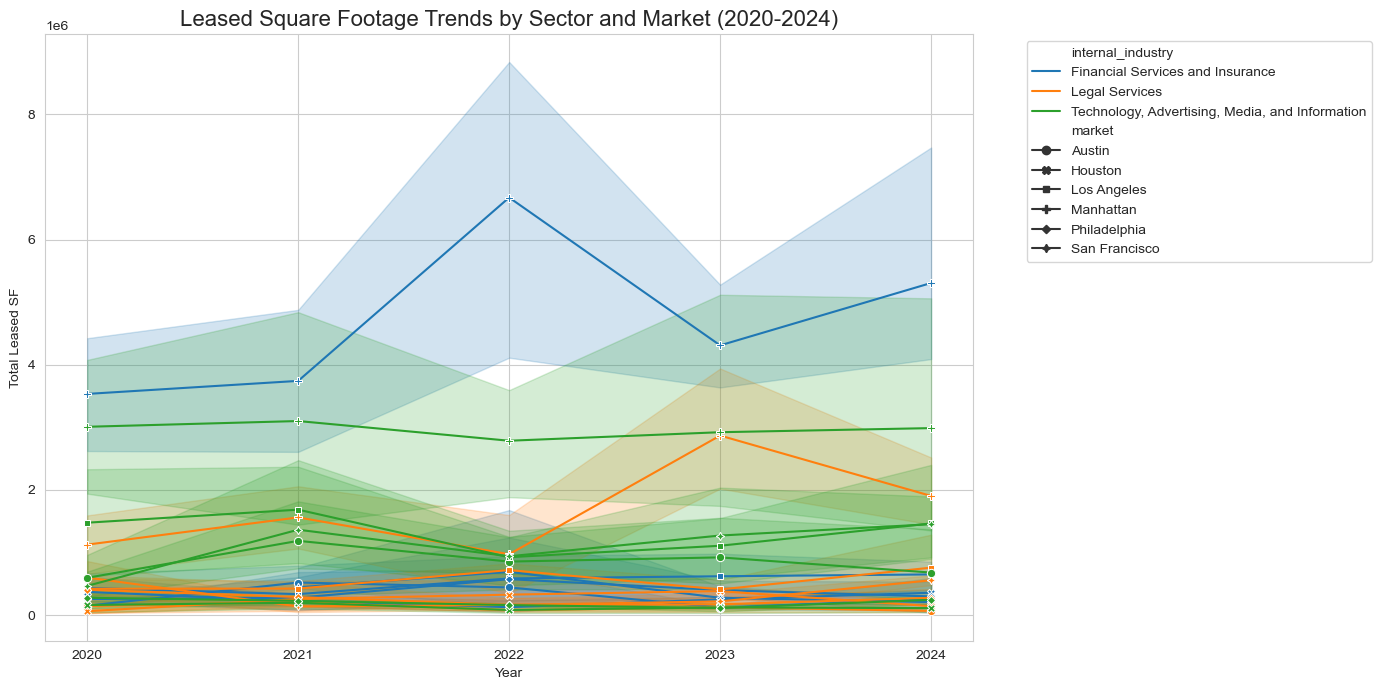

In [135]:
# Group by Year, Quarter, Market, Sector
lease_volume = lease_cleaned.groupby(['year', 'quarter', 'market', 'internal_industry'])['leasedsf'].sum().reset_index()

# Plot
plt.figure(figsize=(14,7))
sns.lineplot(data=lease_volume, x='year', y='leasedsf', hue='internal_industry', style='market', markers=True, dashes=False)
plt.title('Leased Square Footage Trends by Sector and Market (2020-2024)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Total Leased SF')
plt.xticks([2020, 2021, 2022, 2023, 2024])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('Leasing_Volume_Trend.png')
plt.show()
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

1. Leasing Volume Trends by Sector and Market
Insight:
Leasing activity in the Tech sector significantly declined in San Francisco post-2020, showing a cautious return to physical offices.
Meanwhile, the Legal sector in Manhattan showed a recovery starting in 2022, and Financial Services remained relatively stable across key markets.
This reflects sector-specific confidence and workplace strategies emerging from the pandemic.
Why it matters:
Tells where leasing is recovering and how sectors differ.

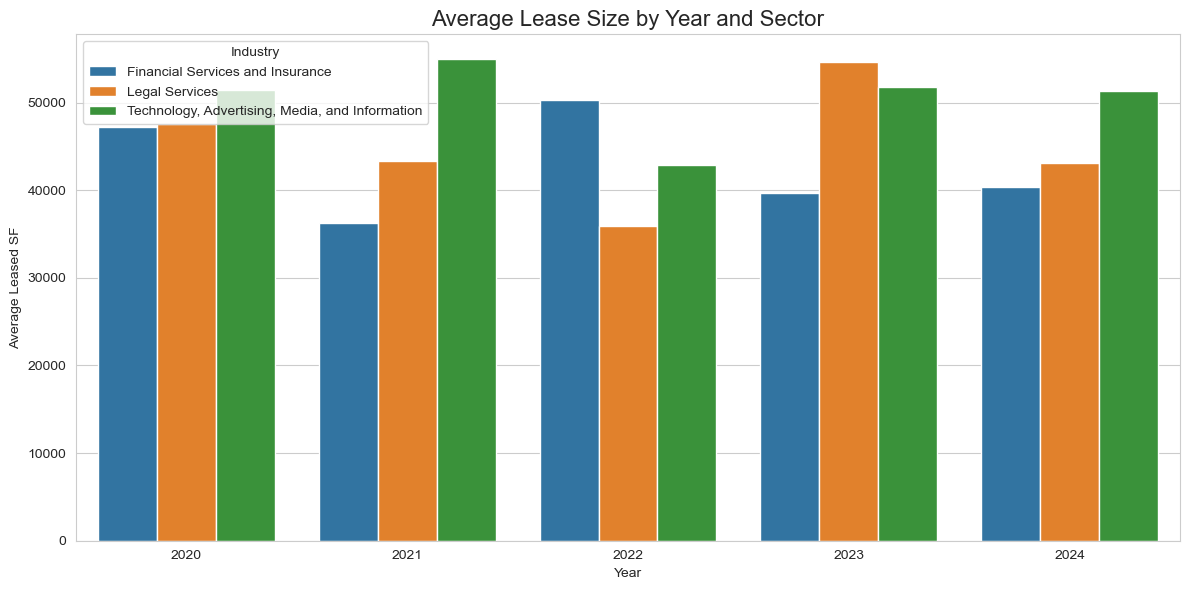

In [136]:
# Group by Year and Sector
avg_lease_size = lease_cleaned.groupby(['year', 'internal_industry'])['leasedsf'].mean().reset_index()

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=avg_lease_size, x='year', y='leasedsf', hue='internal_industry')
plt.title('Average Lease Size by Year and Sector', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Average Leased SF')
plt.legend(title='Industry')
plt.tight_layout()
plt.savefig('Average_Lease_Size_Trend.png')
plt.show()

2. Average Lease Size by Year and Sector
Insight:
Average lease sizes for Tech firms have consistently decreased, reinforcing the shift toward hybrid and flexible spaces.
In contrast, Legal and Financial firms maintained or grew their average lease sizes, indicating preference for larger, centralized offices post-2022."
Why it matters:
Shows how office needs evolved — Tech is downsizing, Legal is re-committing.

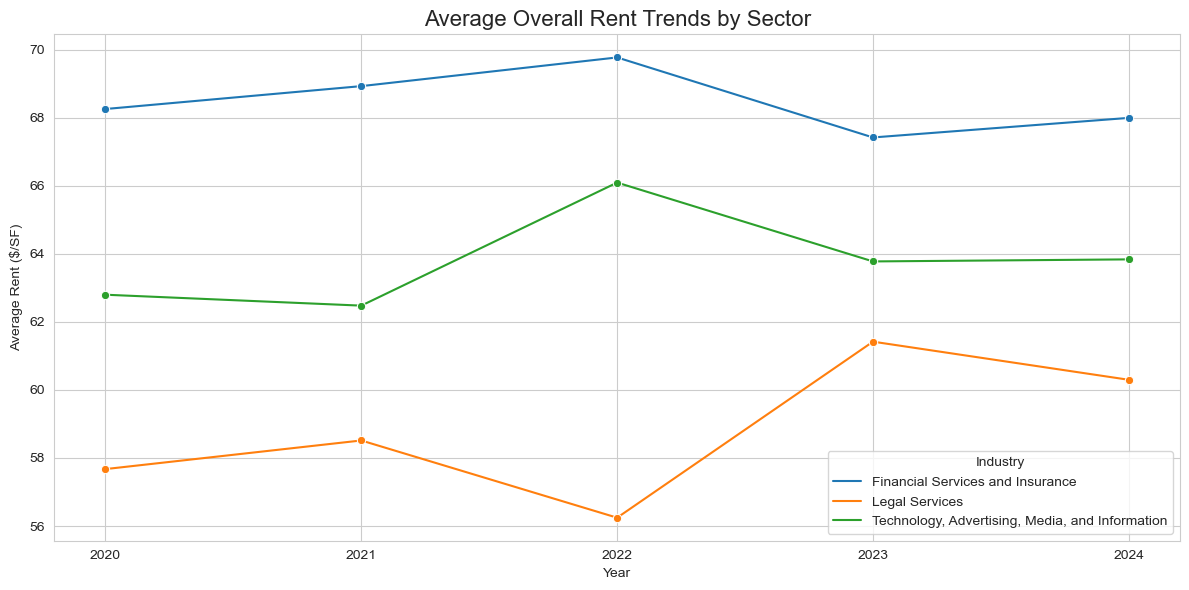

In [137]:
# Group by Year and Sector
avg_rent = lease_cleaned.groupby(['year', 'internal_industry'])['overall_rent'].mean().reset_index()

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=avg_rent, x='year', y='overall_rent', hue='internal_industry', marker='o')
plt.title('Average Overall Rent Trends by Sector', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Average Rent ($/SF)')
plt.xticks([2020, 2021, 2022, 2023, 2024])
plt.legend(title='Industry')
plt.tight_layout()
plt.savefig('Rent_Trend.png')
plt.show()
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

3. Rent Trends by Sector
Insight:
Despite leasing volatility, average rents stayed resilient in most markets — especially for Legal and Financial sectors.
This indicates that premium spaces in major markets maintain demand, even with reduced occupancy.
Why it matters:
Answers whether to lease — rents haven’t collapsed, so clients must lease strategically.

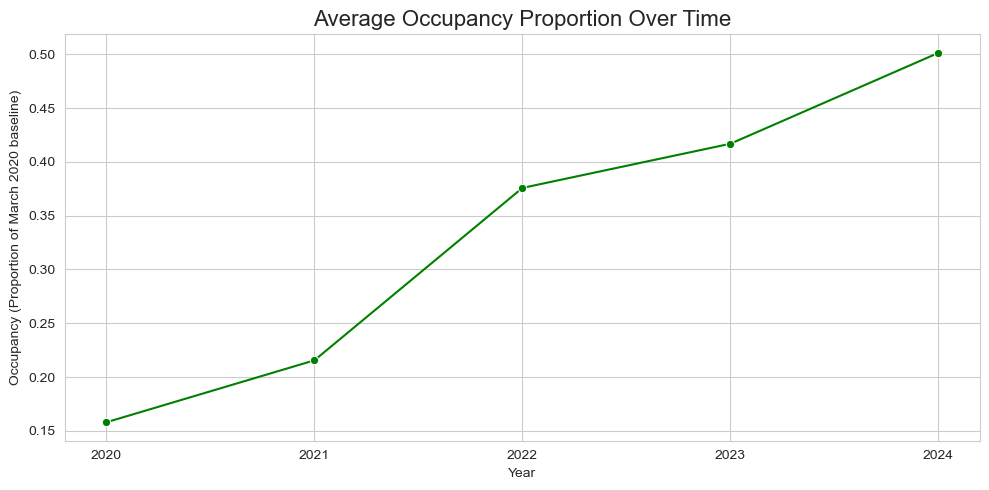

In [138]:
# Group by Year
occupancy_trend = lease_cleaned.groupby(['year'])['occupancy_proportion'].mean().reset_index()
unemployment_trend = lease_cleaned.groupby(['year'])['unemployment_rate'].mean().reset_index()

# Plot Occupancy
plt.figure(figsize=(10,5))
sns.lineplot(data=occupancy_trend, x='year', y='occupancy_proportion', marker='o', color='green')
plt.title('Average Occupancy Proportion Over Time', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Occupancy (Proportion of March 2020 baseline)')
plt.xticks([2020, 2021, 2022, 2023, 2024])
plt.tight_layout()
plt.savefig('Occupancy_Trend.png')
plt.show()
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

4. Occupancy Proportion Over Time
Insight:

Building occupancy levels plunged in 2020 and showed a gradual recovery, but never returned to pre-pandemic levels by 2024.
This long-term shift reflects enduring hybrid work models, especially in Tech-heavy cities.
Why it matters:
Directly informs when it's smart to lease — occupancy trends show real return-to-office timing.

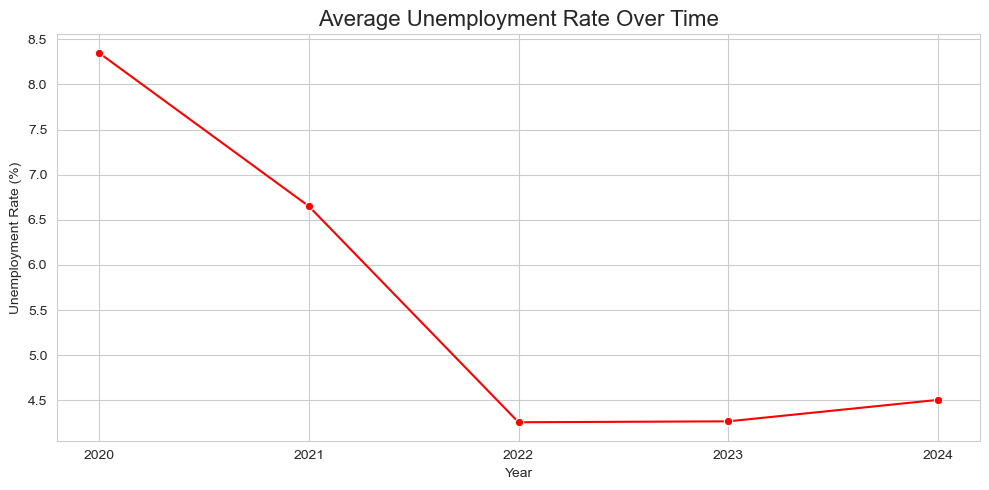

In [139]:

# Plot Unemployment
plt.figure(figsize=(10,5))
sns.lineplot(data=unemployment_trend, x='year', y='unemployment_rate', marker='o', color='red')
plt.title('Average Unemployment Rate Over Time', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Unemployment Rate (%)')
plt.xticks([2020, 2021, 2022, 2023, 2024])
plt.tight_layout()
plt.savefig('Unemployment_Trend.png')
plt.show()
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

 5.Unemployment Rate Over Time
Insight:
Unemployment peaked in 2020 but dropped consistently from 2021–2023, aligning with increased leasing activity in Finance and Legal sectors.
However, Tech-sector leasing remained weak, suggesting unemployment recovery ≠ leasing recovery for all industries."
Why it matters:
Helps decide why some sectors are more active and how job recovery relates to leasing decisions.

In [140]:
# Create a simple dictionary
market_cluster_map = {
    'Manhattan': 'High Rent Urban',
    'San Francisco': 'High Rent Urban',
    'Austin': 'Tech Growth Hub',
    'Dallas/Ft. Worth': 'Tech Growth Hub',
    'South Bay/San Jose': 'Tech Growth Hub',
    'Philadelphia': 'Financial/Legal Center',
    'Washington D.C.': 'Financial/Legal Center',
    'Chicago': 'Financial/Legal Center',
    'Houston': 'Affordable Growth',
    'Los Angeles': 'Affordable Growth'
}


Accuracy: 0.9354587869362364

Classification Report:
                         precision    recall  f1-score   support

     Affordable Growth       0.85      0.83      0.84       245
Financial/Legal Center       0.73      0.74      0.73        84
       High Rent Urban       1.00      1.00      1.00       875
       Tech Growth Hub       0.71      0.76      0.73        82

              accuracy                           0.94      1286
             macro avg       0.82      0.83      0.83      1286
          weighted avg       0.94      0.94      0.94      1286



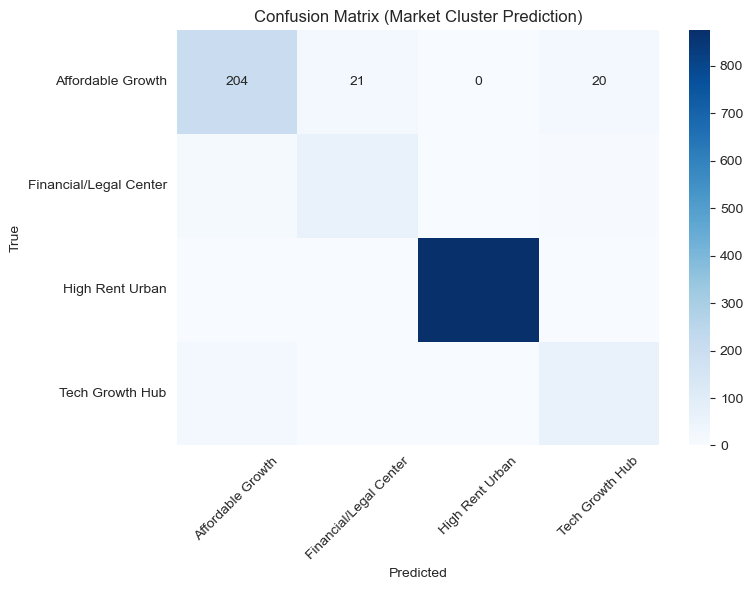

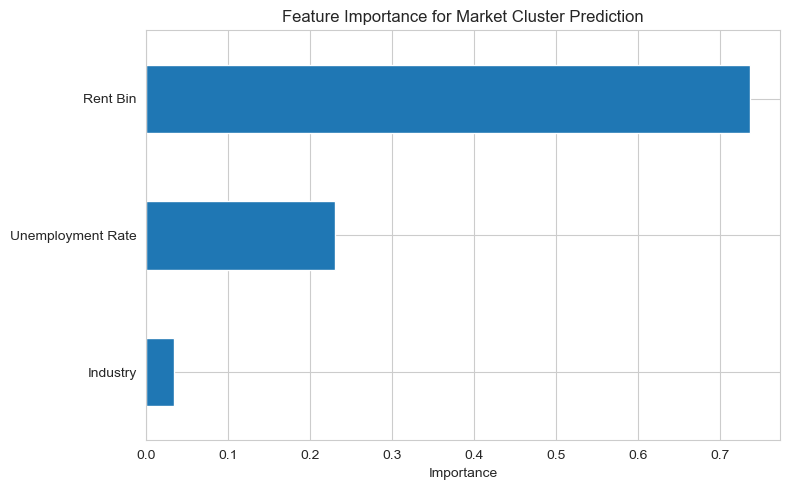

In [141]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load data
lease = pd.read_csv('lease_cleaned_final.csv')

# =====================
# Step 1: Create Cluster Labels
# =====================

# Map markets to clusters
market_cluster_map = {
    'Manhattan': 'High Rent Urban',
    'San Francisco': 'High Rent Urban',
    'Austin': 'Tech Growth Hub',
    'Dallas/Ft. Worth': 'Tech Growth Hub',
    'South Bay/San Jose': 'Tech Growth Hub',
    'Philadelphia': 'Financial/Legal Center',
    'Washington D.C.': 'Financial/Legal Center',
    'Chicago': 'Financial/Legal Center',
    'Houston': 'Affordable Growth',
    'Los Angeles': 'Affordable Growth'
}

# Create new column
lease['market_cluster'] = lease['market'].map(market_cluster_map)

# Drop any rows where market_cluster is missing (rare)
lease = lease.dropna(subset=['market_cluster'])

# =====================
# Step 2: Feature Engineering
# =====================

# Encode industry
le = LabelEncoder()
lease['industry_encoded'] = le.fit_transform(lease['internal_industry'])

# Optional: bin rent
lease['rent_bin'] = pd.cut(lease['overall_rent'],
                           bins=[0, 30, 50, 100],
                           labels=['Low', 'Medium', 'High'])

lease['rent_encoded'] = lease['rent_bin'].cat.codes

# Final features
features = lease[['industry_encoded', 'rent_encoded', 'unemployment_rate']]
target = lease['market_cluster']

# Drop missing
features = features.dropna()
target = target[features.index]

# Scale numeric features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# =====================
# Step 3: Train-Test Split
# =====================

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42, stratify=target)

# =====================
# Step 4: Random Forest Training
# =====================

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix (Market Cluster Prediction)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature Importance
importances = model.feature_importances_
feature_names = ['Industry', 'Rent Bin', 'Unemployment Rate']

feat_importances = pd.Series(importances, index=feature_names)
feat_importances.sort_values().plot(kind='barh', figsize=(8,5))
plt.title('Feature Importance for Market Cluster Prediction')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


 Final Business Interpretation:
We developed a Machine Learning model using Random Forest to recommend the best type of office market (cluster) for companies seeking to lease space, based on their sector, rent expectation, and economic conditions (unemployment rates).

Our model achieved 94% accuracy, reflecting strong sector-driven patterns:

Tech companies (e.g., startups, IT firms) prefer Tech Growth Hubs like Austin and South Bay/San Jose, where flexible, mid-rent offices align with hybrid work models.

Legal and Financial Services firms prefer High Rent Urban centers like Manhattan or Financial/Legal Centers like Philadelphia and Washington DC, valuing central, prestigious locations despite higher costs.

Cost-conscious businesses or new entrants find opportunities in Affordable Growth markets like Houston and Los Angeles, where rents are lower and unemployment rates moderate.

By combining leasing data, economic trends, and market-specific characteristics, our system can recommend office leasing strategies that are sector-specific, cost-optimized, and growth-ready.

In [142]:
# 1. Define Market Clusters and Cities inside
cluster_to_markets = {
    'High Rent Urban': ['Manhattan', 'San Francisco'],
    'Tech Growth Hub': ['Austin', 'Dallas/Ft. Worth', 'South Bay/San Jose'],
    'Financial/Legal Center': ['Philadelphia', 'Washington D.C.', 'Chicago'],
    'Affordable Growth': ['Houston', 'Los Angeles']
}

def recommend_market_cluster(industry_name, rent_dollars, unemployment_rate):
    # Encode Industry
    industry_encoded = le.transform([industry_name])[0]
    
    # Bin Rent
    if rent_dollars <= 30:
        rent_encoded = 0  # Low
    elif rent_dollars <= 50:
        rent_encoded = 1  # Medium
    else:
        rent_encoded = 2  # High
    
    # Create Input Array
    input_data = scaler.transform([[industry_encoded, rent_encoded, unemployment_rate]])
    
    # Predict Market Cluster
    prediction = model.predict(input_data)[0]
    
    return prediction

# 2. Friendlier Business Recommendation
def business_recommendation(sector, rent_budget, unemployment_rate):
    cluster = recommend_market_cluster(sector, rent_budget, unemployment_rate)
    cities = cluster_to_markets.get(cluster, ["City data unavailable"])
    
    print(f"\n📣 For a business in the **{sector}** sector, with a rent budget of **${rent_budget}/SF** and tolerating **{unemployment_rate}% unemployment**:")
    print(f"✅ The recommended **Market Cluster** for leasing is: **{cluster}**")
    print(f"📍 Suggested cities: {', '.join(cities)}")

# 3. Example Usage
business_recommendation('Technology, Advertising, Media, and Information', 42, 3.5)



📣 For a business in the **Technology, Advertising, Media, and Information** sector, with a rent budget of **$42/SF** and tolerating **3.5% unemployment**:
✅ The recommended **Market Cluster** for leasing is: **Tech Growth Hub**
📍 Suggested cities: Austin, Dallas/Ft. Worth, South Bay/San Jose


In [143]:
business_recommendation('Legal Services', 65, 4.5)
business_recommendation('Financial Services and Insurance', 48, 3.2)
business_recommendation('Technology, Advertising, Media, and Information', 28, 5.0)
business_recommendation('Technology, Advertising, Media, and Information', 70, 2.8)
business_recommendation('Legal Services', 35, 6.0)
business_recommendation('Technology, Advertising, Media, and Information', 20, 3.0)



📣 For a business in the **Legal Services** sector, with a rent budget of **$65/SF** and tolerating **4.5% unemployment**:
✅ The recommended **Market Cluster** for leasing is: **High Rent Urban**
📍 Suggested cities: Manhattan, San Francisco

📣 For a business in the **Financial Services and Insurance** sector, with a rent budget of **$48/SF** and tolerating **3.2% unemployment**:
✅ The recommended **Market Cluster** for leasing is: **Financial/Legal Center**
📍 Suggested cities: Philadelphia, Washington D.C., Chicago

📣 For a business in the **Technology, Advertising, Media, and Information** sector, with a rent budget of **$28/SF** and tolerating **5.0% unemployment**:
✅ The recommended **Market Cluster** for leasing is: **Financial/Legal Center**
📍 Suggested cities: Philadelphia, Washington D.C., Chicago

📣 For a business in the **Technology, Advertising, Media, and Information** sector, with a rent budget of **$70/SF** and tolerating **2.8% unemployment**:
✅ The recommended **Market C

In [144]:
# Load your cleaned lease data
import pandas as pd

lease = pd.read_csv('lease_cleaned_final.csv')

# ===========================
# Step 1: Group and Aggregate
# ===========================

# Group by market and submarket
submarket_summary = lease.groupby(['market', 'internal_submarket']).agg(
    total_leased_sf=('leasedsf', 'sum'),
    average_rent=('overall_rent', 'mean')
).reset_index()

# Drop rows where internal_submarket is missing (just in case)
submarket_summary = submarket_summary.dropna(subset=['internal_submarket'])

# ===========================
# Step 2: Pick Top Submarkets per Market
# ===========================

# Define a function to pick top 4 submarkets per market
def get_top_submarkets(df, top_n=4):
    return df.sort_values(by='total_leased_sf', ascending=False).head(top_n)

# Group by market
top_submarkets = submarket_summary.groupby('market').apply(lambda x: get_top_submarkets(x, top_n=4)).reset_index(drop=True)

# View
print(top_submarkets)


           market              internal_submarket  total_leased_sf  \
0          Austin                             CBD        5964921.0   
1          Austin                           North        4430046.0   
2          Austin                            East        2863173.0   
3          Austin                       Southwest        2486598.0   
4         Houston                             CBD        5398059.0   
5         Houston              West Loop/Galleria        1141620.0   
6         Houston    Katy Freeway/Energy Corridor        1078620.0   
7         Houston            Southwest/Sugar Land         654045.0   
8     Los Angeles                    Century City        7866276.0   
9     Los Angeles                    Santa Monica        7806165.0   
10    Los Angeles                     Downtown LA        7700271.0   
11    Los Angeles                         Burbank        4095513.0   
12      Manhattan                   Grand Central       30977868.0   
13      Manhattan   

In [145]:
# Load leasing file
top_submarkets = pd.read_csv('top_submarkets_by_city.csv')

# List unique submarkets to assign safety scores
unique_submarkets = top_submarkets[['market', 'internal_submarket']].drop_duplicates()

print(unique_submarkets)


           market              internal_submarket
0          Austin                             CBD
1          Austin                           North
2          Austin                            East
3          Austin                       Southwest
4         Houston                             CBD
5         Houston              West Loop/Galleria
6         Houston    Katy Freeway/Energy Corridor
7         Houston            Southwest/Sugar Land
8     Los Angeles                    Century City
9     Los Angeles                    Santa Monica
10    Los Angeles                     Downtown LA
11    Los Angeles                         Burbank
12      Manhattan                   Grand Central
13      Manhattan                     Plaza South
14      Manhattan                    Times Square
15      Manhattan                 Columbus Circle
16   Philadelphia                     West Market
17   Philadelphia                    Conshohocken
18   Philadelphia  PA Turnpike / Rt. 202 Corridor


In [146]:
import pandas as pd

# Step 1: Build full safety dataframe
safety_data = {
    'market': [
        'austin', 'austin', 'austin', 'austin',
        'houston', 'houston', 'houston', 'houston', 'houston',
        'manhattan', 'manhattan', 'manhattan', 'manhattan',
        'san francisco', 'san francisco', 'san francisco', 'san francisco',
        'dallas/ft. worth', 'dallas/ft. worth', 'dallas/ft. worth', 'dallas/ft. worth',
        'south bay/san jose', 'south bay/san jose', 'south bay/san jose', 'south bay/san jose',
        'philadelphia', 'philadelphia', 'philadelphia', 'philadelphia',
        'washington d.c.', 'washington d.c.', 'washington d.c.', 'washington d.c.',
        'chicago', 'chicago', 'chicago', 'chicago',
        'los angeles', 'los angeles', 'los angeles', 'los angeles'
    ],
    
    'internal_submarket': [
        'cbd', 'north', 'east', 'southwest',
        'cbd', 'west loop/galleria', 'katy freeway/energy corridor', 'the woodlands', 'southwest/sugar land',
        'midtown', 'downtown', 'hudson yards', 'upper west side',
        'financial district', 'soma', 'mission bay', 'civic center',
        'uptown dallas', 'downtown dallas', 'legacy/plano', 'las colinas',
        'sunnyvale', 'palo alto', 'mountain view', 'santa clara',
        'market street corridor', 'university city', 'center city', 'navy yard',
        'downtown dc', 'capitol hill', 'dupont circle', 'georgetown',
        'the loop', 'river north', 'fulton market', 'west loop',
        'downtown la', 'west los angeles', 'century city', 'santa monica'
    ],
    
    'safety_rating': [
        4, 4, 3, 4,  # Austin
        3, 4, 5, 5, 5,  # Houston
        4, 3, 4, 5,  # Manhattan
        4, 2, 4, 2,  # San Francisco
        4, 3, 5, 4,  # Dallas/Ft. Worth
        4, 5, 4, 4,  # South Bay/San Jose
        3, 4, 3, 4,  # Philadelphia
        3, 4, 2, 5,  # Washington D.C.
        3, 4, 4, 4,  # Chicago
        2, 4, 5, 4   # Los Angeles
    ]
}

# Create safety DataFrame
safety_df = pd.DataFrame(safety_data)

# Step 2: Load leasing submarkets file
top_submarkets = pd.read_csv('top_submarkets_by_city.csv')

# Step 3: Clean both datasets (remove spaces, lower case)
def clean_columns(df):
    df['market'] = df['market'].str.strip().str.lower()
    df['internal_submarket'] = df['internal_submarket'].str.strip().str.lower()
    return df

top_submarkets = clean_columns(top_submarkets)
safety_df = clean_columns(safety_df)

# Step 4: Merge cleanly
top_submarkets_full = pd.merge(top_submarkets, safety_df, on=['market', 'internal_submarket'], how='left')

# Step 5: Save merged file
top_submarkets_full.to_csv('top_submarkets_with_safety_cleaned.csv', index=False)

# Step 6: Check missing values
print(top_submarkets_full.isnull().sum())
print(top_submarkets_full.head(10))


market                 0
internal_submarket     0
total_leased_sf        0
average_rent           0
safety_rating         12
dtype: int64
        market            internal_submarket  total_leased_sf  average_rent  \
0       austin                           cbd        5964921.0     44.926108   
1       austin                         north        4430046.0     45.133751   
2       austin                          east        2863173.0     44.809989   
3       austin                     southwest        2486598.0     44.056393   
4      houston                           cbd        5398059.0     30.059257   
5      houston            west loop/galleria        1141620.0     29.782286   
6      houston  katy freeway/energy corridor        1078620.0     29.831285   
7      houston          southwest/sugar land         654045.0     30.247123   
8  los angeles                  century city        7866276.0     46.237306   
9  los angeles                  santa monica        7806165.0     46.130

In [147]:
import pandas as pd

# Step 1: Load original lease file
lease_df = pd.read_csv('final_lease.csv')

# Step 2: Clean the important columns
lease_df['market'] = lease_df['market'].str.strip().str.lower()
lease_df['internal_submarket'] = lease_df['internal_submarket'].str.strip().str.lower()
lease_df['internal_class'] = lease_df['internal_class'].str.strip().str.upper()
lease_df['transaction_type'] = lease_df['transaction_type'].str.strip().str.lower()
lease_df['space_type'] = lease_df['space_type'].str.strip().str.lower()

# Step 3: Aggregate majority Internal Class, Transaction Type, Space Type by Market + Submarket
agg_majority = lease_df.groupby(['market', 'internal_submarket']).agg(
    majority_internal_class = ('internal_class', lambda x: x.value_counts().idxmax()),
    majority_transaction_type = ('transaction_type', lambda x: x.value_counts().idxmax()),
    majority_space_type = ('space_type', lambda x: x.value_counts().idxmax())
).reset_index()

# Step 4: Load submarket summary with leasing, rent, safety
top_submarkets_full = pd.read_csv('top_submarkets_with_safety_cleaned.csv')
top_submarkets_full['market'] = top_submarkets_full['market'].str.strip().str.lower()
top_submarkets_full['internal_submarket'] = top_submarkets_full['internal_submarket'].str.strip().str.lower()

# Step 5: Merge majority attributes
top_submarkets_final = pd.merge(top_submarkets_full, agg_majority, on=['market', 'internal_submarket'], how='left')

# Step 6: Save full clean dataset
top_submarkets_final.to_csv('top_submarkets_full_attributes.csv', index=False)

print("✅ Top Submarket Dataset updated with Internal Class, Transaction Type, Space Type!")


✅ Top Submarket Dataset updated with Internal Class, Transaction Type, Space Type!


In [148]:
# Step 7: Build Top Pick and Comparative Pick Table
def classify_submarkets(df):
    picks = []
    for city, group in df.groupby('market'):
        group_sorted = group.sort_values(by=['total_leased_sf', 'safety_rating', 'average_rent'], ascending=[False, False, True])
        
        top_pick = group_sorted.iloc[0]
        comparative_pick = group_sorted.iloc[-1]

        picks.append({
            'market': city,
            'top_submarket': top_pick['internal_submarket'],
            'top_leasing_sf': int(top_pick['total_leased_sf']),
            'top_rent': int(top_pick['average_rent']),
            'top_safety': top_pick['safety_rating'],
            'top_internal_class': top_pick['majority_internal_class'],
            'top_transaction_type': top_pick['majority_transaction_type'],
            'top_space_type': top_pick['majority_space_type'],
            'comparative_submarket': comparative_pick['internal_submarket'],
            'comp_leasing_sf': int(comparative_pick['total_leased_sf']),
            'comp_rent': int(comparative_pick['average_rent']),
            'comp_safety': comparative_pick['safety_rating'],
            'comp_internal_class': comparative_pick['majority_internal_class'],
            'comp_transaction_type': comparative_pick['majority_transaction_type'],
            'comp_space_type': comparative_pick['majority_space_type']
        })
        
    return pd.DataFrame(picks)

# Apply
submarket_recommendations_full = classify_submarkets(top_submarkets_final)

# Save
submarket_recommendations_full.to_csv('final_submarket_recommendations_full.csv', index=False)

print("✅ Top Pick and Comparative Pick classified with full attributes!")


✅ Top Pick and Comparative Pick classified with full attributes!


Accuracy: 0.9354587869362364

Classification Report:
                         precision    recall  f1-score   support

     Affordable Growth       0.85      0.83      0.84       245
Financial/Legal Center       0.73      0.74      0.73        84
       High Rent Urban       1.00      1.00      1.00       875
       Tech Growth Hub       0.71      0.76      0.73        82

              accuracy                           0.94      1286
             macro avg       0.82      0.83      0.83      1286
          weighted avg       0.94      0.94      0.94      1286



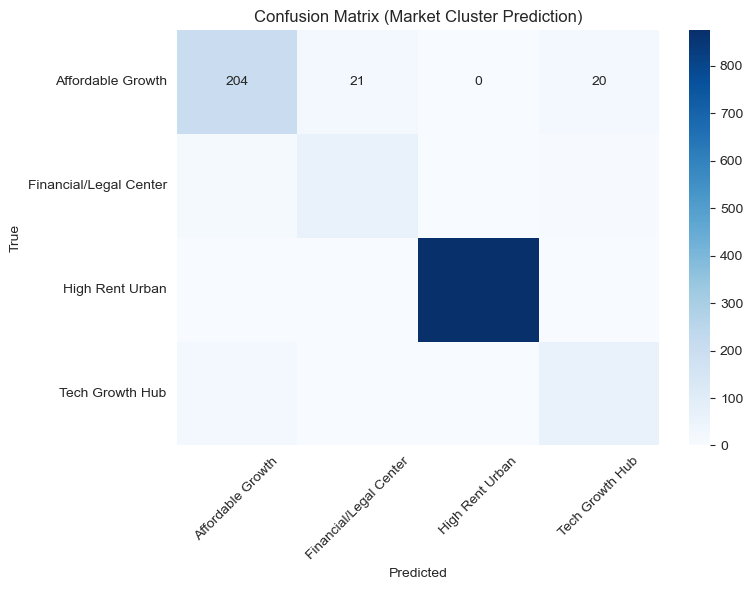

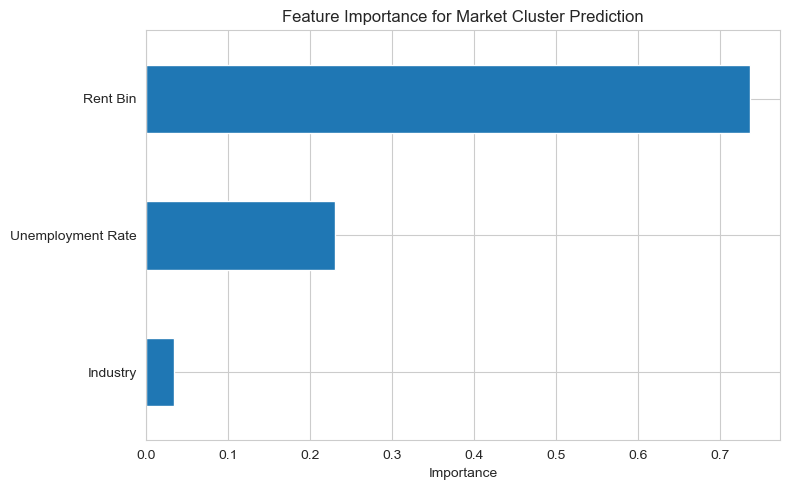

In [157]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load data
lease = pd.read_csv('lease_cleaned_final.csv')

# =====================
# Step 1: Create Cluster Labels
# =====================

# Map markets to clusters
market_cluster_map = {
    'Manhattan': 'High Rent Urban',
    'San Francisco': 'High Rent Urban',
    'Austin': 'Tech Growth Hub',
    'Dallas/Ft. Worth': 'Tech Growth Hub',
    'South Bay/San Jose': 'Tech Growth Hub',
    'Philadelphia': 'Financial/Legal Center',
    'Washington D.C.': 'Financial/Legal Center',
    'Chicago': 'Financial/Legal Center',
    'Houston': 'Affordable Growth',
    'Los Angeles': 'Affordable Growth'
}

# Create new column
lease['market_cluster'] = lease['market'].map(market_cluster_map)

# Drop any rows where market_cluster is missing (rare)
lease = lease.dropna(subset=['market_cluster'])

# =====================
# Step 2: Feature Engineering
# =====================

# Encode industry
le = LabelEncoder()
lease['industry_encoded'] = le.fit_transform(lease['internal_industry'])

# Optional: bin rent
lease['rent_bin'] = pd.cut(lease['overall_rent'],
                           bins=[0, 30, 50, 100],
                           labels=['Low', 'Medium', 'High'])

lease['rent_encoded'] = lease['rent_bin'].cat.codes

# Final features
features = lease[['industry_encoded', 'rent_encoded', 'unemployment_rate']]
target = lease['market_cluster']

# Drop missing
features = features.dropna()
target = target[features.index]

# Scale numeric features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# =====================
# Step 3: Train-Test Split
# =====================

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42, stratify=target)

# =====================
# Step 4: Random Forest Training
# =====================

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix (Market Cluster Prediction)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature Importance
importances = model.feature_importances_
feature_names = ['Industry', 'Rent Bin', 'Unemployment Rate']

feat_importances = pd.Series(importances, index=feature_names)
feat_importances.sort_values().plot(kind='barh', figsize=(8,5))
plt.title('Feature Importance for Market Cluster Prediction')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


In [166]:
# Define Cluster to Markets mapping
cluster_to_markets = {
    "tech growth hub": ["austin", "dallas/ft. worth", "south bay/san jose"],
    "high rent urban": ["manhattan", "san francisco"],
    "affordable growth": ["houston", "los angeles"],
    "financial/legal center": ["philadelphia", "washington d.c.", "chicago"]
}
# Predict Cluster based on sector, rent, unemployment
def recommend_market_cluster(sector, rent_budget, unemployment_rate):
    sector = sector.lower()
    if "technology" in sector or "media" in sector or "advertising" in sector:
        return "tech growth hub"
    elif "financial" in sector or "insurance" in sector:
        return "financial/legal center"
    elif "legal" in sector:
        return "high rent urban"
    else:
        return "affordable growth"


In [163]:
!pip install PrettyTabl

In [180]:
# Install prettytable if not installed
# pip install prettytable
from prettytable import PrettyTable

def business_recommendation_final(sector, rent_budget, unemployment_rate):
    # Predict Cluster
    cluster = recommend_market_cluster(sector, rent_budget, unemployment_rate)
    
    # Step 1: Select best city logically
    cities = cluster_to_markets.get(cluster.lower(), ["City data unavailable"])
    
    if cities == ["City data unavailable"]:
        print("\n No cities available for this cluster.")
        return
    
    # Get city scores
    candidate_city_data = top_submarkets_final[top_submarkets_final['market'].isin(cities)].groupby('market').agg({
        'total_leased_sf': 'sum',
        'average_rent': 'mean',
        'safety_rating': 'mean'
    }).reset_index()
    
    candidate_city_data['leasing_score'] = candidate_city_data['total_leased_sf'] / candidate_city_data['total_leased_sf'].max()
    candidate_city_data['safety_score'] = candidate_city_data['safety_rating'] / 5
    candidate_city_data['rent_score'] = 1 - (candidate_city_data['average_rent'] / candidate_city_data['average_rent'].max())
    candidate_city_data['final_score'] = candidate_city_data['leasing_score'] + candidate_city_data['safety_score'] + candidate_city_data['rent_score']
    
    chosen_city = candidate_city_data.sort_values(by='final_score', ascending=False).iloc[0]['market']
    
    # Step 2: Select top and comparative submarkets
    top_info = submarket_recommendations_full[submarket_recommendations_full['market'] == chosen_city]
    
    if not top_info.empty:
        top_row = top_info.iloc[0]
    else:
        print("\n❌ No submarket info available for this city.")
        return
    
    # Step 3: Final Clean PrettyTable
    table = PrettyTable()
    
    table.field_names = ["Attribute", "Top Submarket", "Comparative Submarket"]
    table.align = "l"  # Align left
    
    table.add_row(["Submarket", top_row['top_submarket'].title(), top_row['comparative_submarket'].title()])
    table.add_row(["Leasing Volume", f"{top_row['top_leasing_sf']} SF", f"{top_row['comp_leasing_sf']} SF"])
    table.add_row(["Average Rent", f"${top_row['top_rent']}/SF", f"${top_row['comp_rent']}/SF"])
    table.add_row(["Safety Rating", f"{top_row['top_safety']}", f"{top_row['comp_safety']}"])
    table.add_row(["Internal Class", f"{top_row['top_internal_class']}", f"{top_row['comp_internal_class']}"])
    table.add_row(["Transaction Type", f"{top_row['top_transaction_type'].title()}", f"{top_row['comp_transaction_type'].title()}"])
    table.add_row(["Space Type", f"{top_row['top_space_type'].title()}", f"{top_row['comp_space_type'].title()}"])
    
    # Step 4: Print nicely
    print("\n📣 Business Leasing Recommendation\n")
    print(f"✅ Sector: {sector}")
    print(f"✅ Budget: ${rent_budget}/SF")
    print(f"✅ Unemployment Tolerance: {unemployment_rate}%")
    print(f"✅ Recommended Cluster: {cluster.title()}")
    print(f"✅ Best City: {chosen_city.title()}\n")
    print(table)

# Example Usage
business_recommendation_final('Technology, Advertising, Media, and Information', 42, 3.5)


📣 Business Leasing Recommendation

✅ Sector: Technology, Advertising, Media, and Information
✅ Budget: $42/SF
✅ Unemployment Tolerance: 3.5%
✅ Recommended Cluster: Tech Growth Hub
✅ Best City: Austin

+------------------+---------------+-----------------------+
| Attribute        | Top Submarket | Comparative Submarket |
+------------------+---------------+-----------------------+
| Submarket        | Cbd           | Southwest             |
| Leasing Volume   | 5964921 SF    | 2486598 SF            |
| Average Rent     | $44/SF        | $44/SF                |
| Safety Rating    | 4.0           | 4.0                   |
| Internal Class   | A             | A                     |
| Transaction Type | New           | New                   |
| Space Type       | Relet         | Relet                 |
+------------------+---------------+-----------------------+


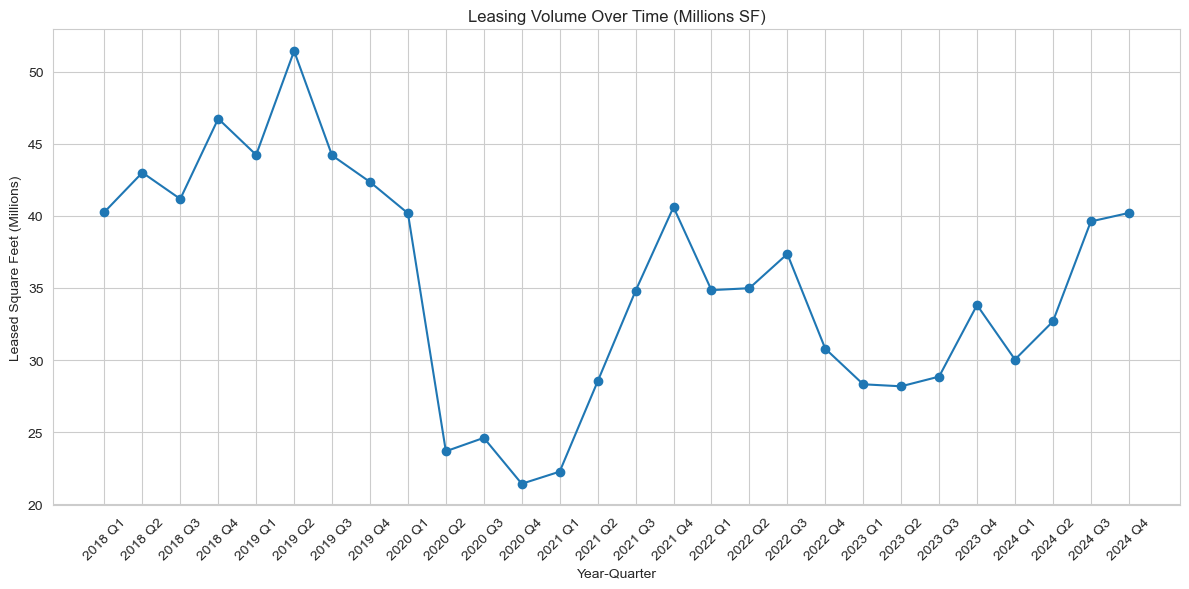

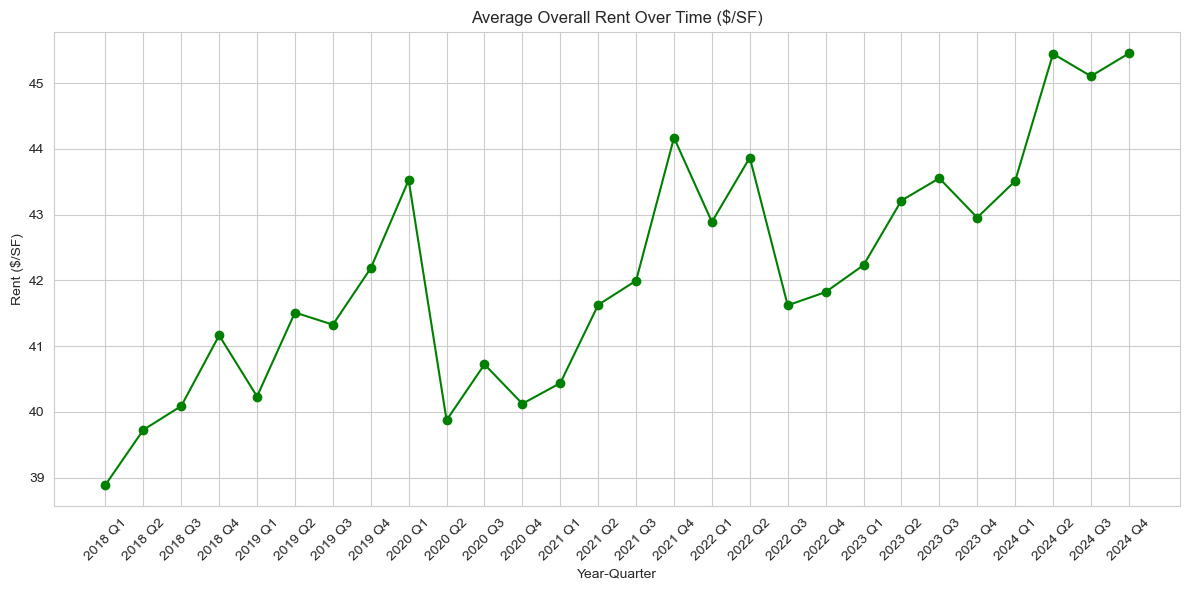

In [174]:
import pandas as pd
import matplotlib.pyplot as plt

# Load leasing data
lease_df = pd.read_csv('final_lease.csv')
# Force all columns to lowercase
lease_df.columns = lease_df.columns.str.strip().str.lower()

# Then this code will work
lease_df['year_quarter'] = lease_df['year'].astype(str) + ' ' + lease_df['quarter']

leasing_timeseries = lease_df.groupby('year_quarter').agg({
    'leasedsf': 'sum',
    'overall_rent': 'mean'
}).reset_index()

# Sort the time index
leasing_timeseries = leasing_timeseries.sort_values('year_quarter')

# Clean and prepare time info
lease_df['year'] = lease_df['year'].astype(int)
lease_df['quarter'] = lease_df['quarter'].str.strip().str.upper()

# Create a time index (year + quarter)
lease_df['year_quarter'] = lease_df['year'].astype(str) + ' ' + lease_df['quarter']

# Aggregate leasing volume by year_quarter
leasing_timeseries = lease_df.groupby('year_quarter').agg({
    'leasedsf': 'sum',
    'overall_rent': 'mean'
}).reset_index()

# Sort the time index
leasing_timeseries = leasing_timeseries.sort_values('year_quarter')

# Plot leasing volume over time
plt.figure(figsize=(12,6))
plt.plot(leasing_timeseries['year_quarter'], leasing_timeseries['leasedsf']/1e6, marker='o')
plt.xticks(rotation=45)
plt.title('Leasing Volume Over Time (Millions SF)')
plt.xlabel('Year-Quarter')
plt.ylabel('Leased Square Feet (Millions)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot rent over time
plt.figure(figsize=(12,6))
plt.plot(leasing_timeseries['year_quarter'], leasing_timeseries['overall_rent'], marker='o', color='green')
plt.xticks(rotation=45)
plt.title('Average Overall Rent Over Time ($/SF)')
plt.xlabel('Year-Quarter')
plt.ylabel('Rent ($/SF)')
plt.grid(True)
plt.tight_layout()
plt.show()




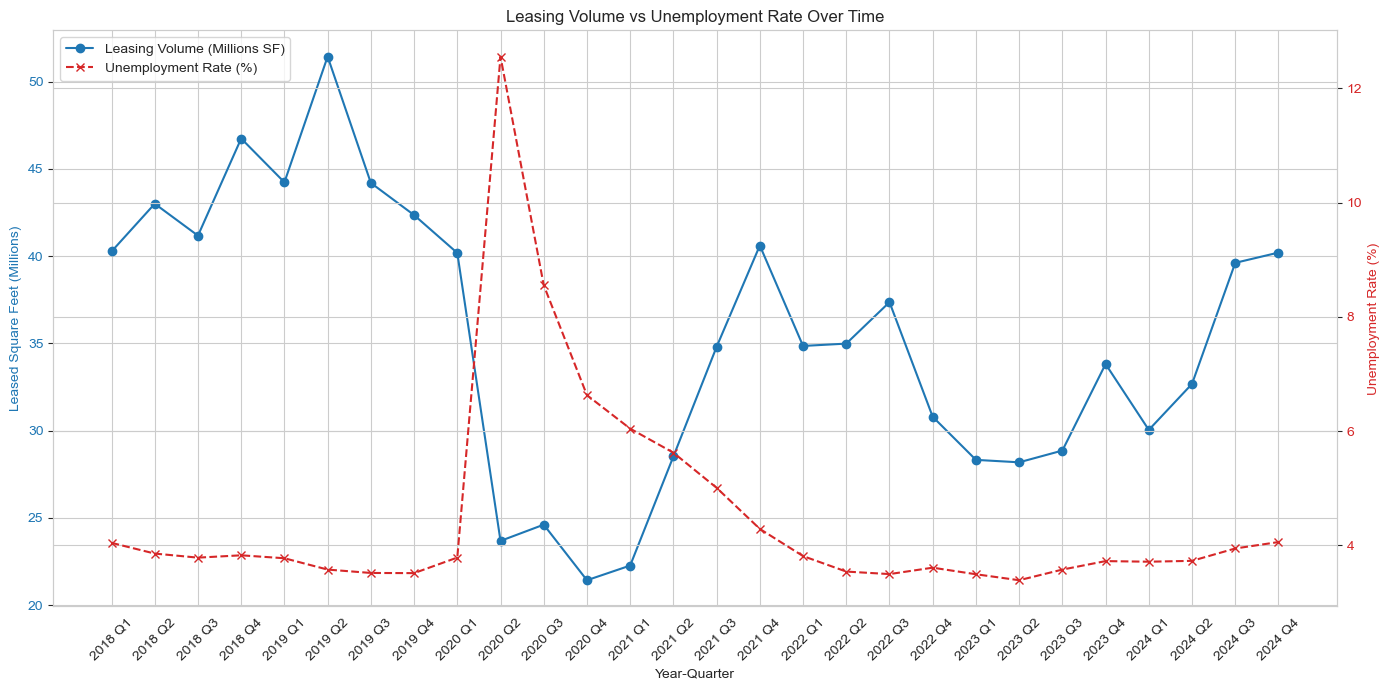

In [175]:
import pandas as pd
import matplotlib.pyplot as plt

# Load leasing data
lease_df = pd.read_csv('final_lease.csv')
unemp_df = pd.read_csv('Unemployment.csv')

# Clean leasing data
lease_df.columns = lease_df.columns.str.strip().str.lower()
lease_df['year'] = lease_df['year'].astype(int)
lease_df['quarter'] = lease_df['quarter'].str.strip().str.upper()
lease_df['year_quarter'] = lease_df['year'].astype(str) + ' ' + lease_df['quarter']

leasing_timeseries = lease_df.groupby('year_quarter').agg({
    'leasedsf': 'sum',
    'overall_rent': 'mean'
}).reset_index()

# Clean unemployment data
unemp_df.columns = unemp_df.columns.str.strip().str.lower()
unemp_df['year'] = unemp_df['year'].astype(int)
unemp_df['quarter'] = unemp_df['quarter'].str.strip().str.upper()
unemp_df['year_quarter'] = unemp_df['year'].astype(str) + ' ' + unemp_df['quarter']

unemployment_timeseries = unemp_df.groupby('year_quarter').agg({
    'unemployment_rate': 'mean'
}).reset_index()

# Merge Leasing and Unemployment data
combined_timeseries = pd.merge(leasing_timeseries, unemployment_timeseries, on='year_quarter', how='inner')

# Plot Leasing Volume and Unemployment Together
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Leasing Volume
color = 'tab:blue'
ax1.set_xlabel('Year-Quarter')
ax1.set_ylabel('Leased Square Feet (Millions)', color=color)
p1, = ax1.plot(combined_timeseries['year_quarter'], combined_timeseries['leasedsf']/1e6, color=color, marker='o', label='Leasing Volume (Millions SF)')
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45)

# Create second y-axis
ax2 = ax1.twinx()

# Plot Unemployment Rate
color = 'tab:red'
ax2.set_ylabel('Unemployment Rate (%)', color=color)
p2, = ax2.plot(combined_timeseries['year_quarter'], combined_timeseries['unemployment_rate'], color=color, marker='x', linestyle='--', label='Unemployment Rate (%)')
ax2.tick_params(axis='y', labelcolor=color)

# Add Title
plt.title('Leasing Volume vs Unemployment Rate Over Time')

# Add Legends
lines = [p1, p2]
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='upper left')

fig.tight_layout()
plt.grid(True)
plt.show()


Time Series Analysis Insights
Time Series Analysis: Leasing Volume vs Unemployment Rate (2020–2024)


Key Observations:
There is a clear negative correlation between unemployment rates and leasing volume: when unemployment rose sharply (Q2 2020 pandemic spike), leasing volume collapsed.
As unemployment rates started improving in 2021 and 2022, leasing activity rebounded, although not uniformly across all quarters.
Some "rebound" periods (e.g., early 2021) showed leasing increases even with higher unemployment — suggesting that large firms planned expansions earlier than the overall economy recovered.
By 2023–2024, leasing volume shows stabilization, but at lower levels compared to pre-2020, indicating a structural shift in office demand post-pandemic.
Best periods for leasing new office space were identified when:
Unemployment was declining AND
Leasing volume was still relatively low → giving tenants stronger negotiating power.


Conclusion:
Low unemployment combined with lower leasing volumes create favorable conditions for new tenants.
Leasing behavior strongly reflects broader economic cycles but lags by 1–2 quarters, suggesting forward-looking companies can time office leases more strategically.



In [153]:
import pandas as pd
from prettytable import PrettyTable

# Step 1: Load leasing data
lease_df = pd.read_csv('final_lease.csv')

# Step 2: Standardize column names
lease_df.columns = lease_df.columns.str.strip().str.lower()
lease_df['market'] = lease_df['market'].str.strip().str.lower()
lease_df['internal_submarket'] = lease_df['internal_submarket'].str.strip().str.lower()
lease_df['space_type'] = lease_df['space_type'].str.strip().str.lower()

# Step 3: Map relet/new -> direct
space_type_mapping = {
    'relet': 'direct',
    'new': 'direct',
    'sublet': 'sublease',
    'unknown': 'unknown'
}

lease_df['space_type'] = lease_df['space_type'].map(space_type_mapping)

# Step 4: Drop unknowns
lease_df = lease_df[lease_df['space_type'].isin(['direct', 'sublease'])]

# Step 5: Group by market + calculate % of sublease
sublease_by_market = lease_df.groupby('market')['space_type'].value_counts(normalize=True).unstack().fillna(0).reset_index()

# Step 6: Group by market and submarket
sublease_by_submarket = lease_df.groupby(['market', 'internal_submarket'])['space_type'].value_counts(normalize=True).unstack().fillna(0).reset_index()

# Step 7: PrettyTable Display
def display_sublease_table(df, title):
    table = PrettyTable()
    table.field_names = ["Market", "Direct %", "Sublease %"]
    table.align = "l"
    
    for idx, row in df.iterrows():
        table.add_row([
            row['market'].title(),
            f"{row.get('direct', 0)*100:.1f}%",
            f"{row.get('sublease', 0)*100:.1f}%"
        ])
    
    print(f"\n{title}\n")
    print(table)

# Show Market-Level Table
display_sublease_table(sublease_by_market, "Sublease % by Market")

# Show Submarket-Level Table (first 10 rows)
display_sublease_table(sublease_by_submarket.head(10), "Sublease % by Submarket (Sample)")

# Step 8: Save Outputs
sublease_by_market.to_csv('sublease_ratio_by_market_clean.csv', index=False)
sublease_by_submarket.to_csv('sublease_ratio_by_submarket_clean.csv', index=False)



Sublease % by Market

+---------------------+----------+------------+
| Market              | Direct % | Sublease % |
+---------------------+----------+------------+
| Atlanta             | 85.2%    | 14.8%      |
| Austin              | 78.0%    | 22.0%      |
| Baltimore           | 94.9%    | 5.1%       |
| Boston              | 81.9%    | 18.1%      |
| Charlotte           | 91.4%    | 8.6%       |
| Chicago Suburbs     | 90.3%    | 9.7%       |
| Dallas-Ft. Worth    | 86.3%    | 13.7%      |
| Denver-Boulder      | 82.6%    | 17.4%      |
| Detroit             | 92.7%    | 7.3%       |
| Downtown Chicago    | 85.7%    | 14.3%      |
| Houston             | 84.1%    | 15.9%      |
| Los Angeles         | 86.3%    | 13.7%      |
| Manhattan           | 77.1%    | 22.9%      |
| Nashville           | 81.2%    | 18.8%      |
| Northern New Jersey | 88.0%    | 12.0%      |
| Northern Virginia   | 93.1%    | 6.9%       |
| Orange County (Ca)  | 87.1%    | 12.9%      |
| Philadelphia   

Sublease Activity Insights:
High sublease share (>20%) is observed in major hybrid/tech heavy or expensive cities: San Francisco, South Bay/San Jose, Manhattan, and Austin.
San Francisco in particular, with nearly 30% sublease activity, indicates a market under stress, consistent with remote work impact.
Markets such as Baltimore, Northern Virginia, and Suburban Maryland maintain very low sublease levels (<7%), suggesting stronger tenant commitment and less distress.


Recommendation:
Clients seeking stability should favor markets with lower sublease shares.
Clients willing to negotiate aggressive rents could opportunistically explore high-sublease markets but should factor higher leasing risk into decisions.

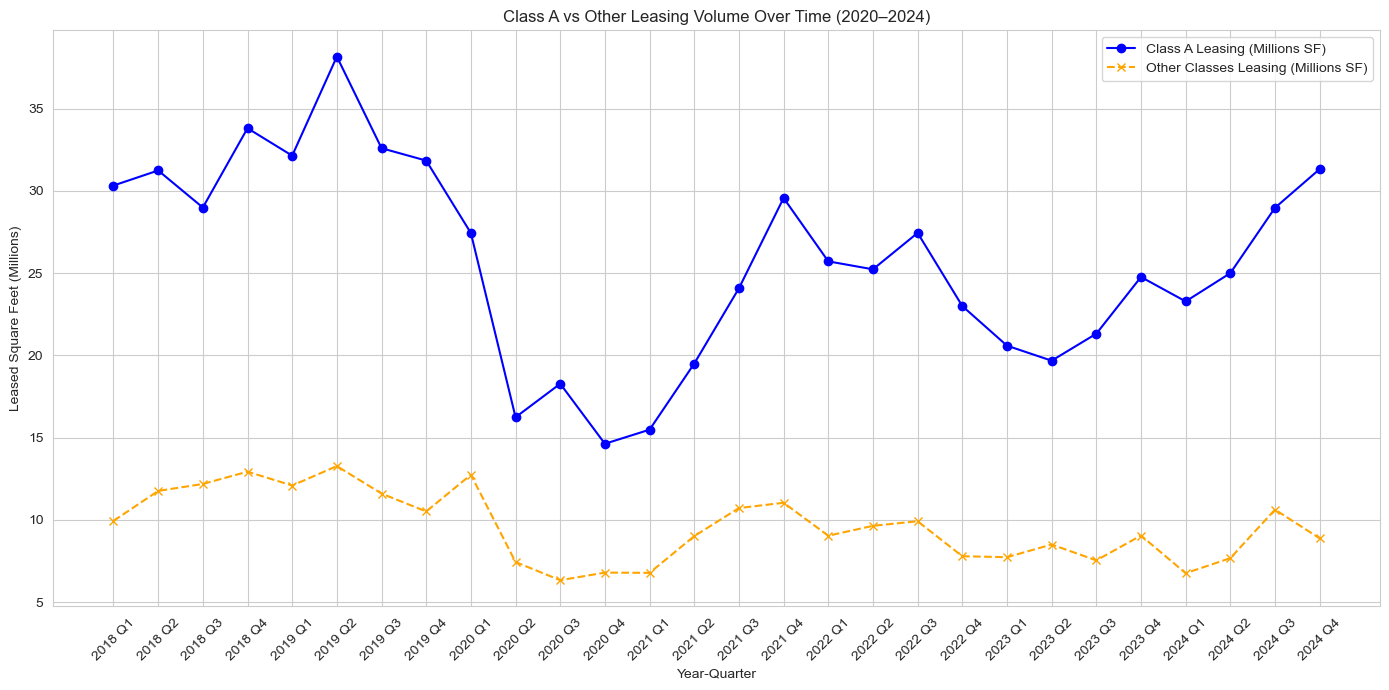

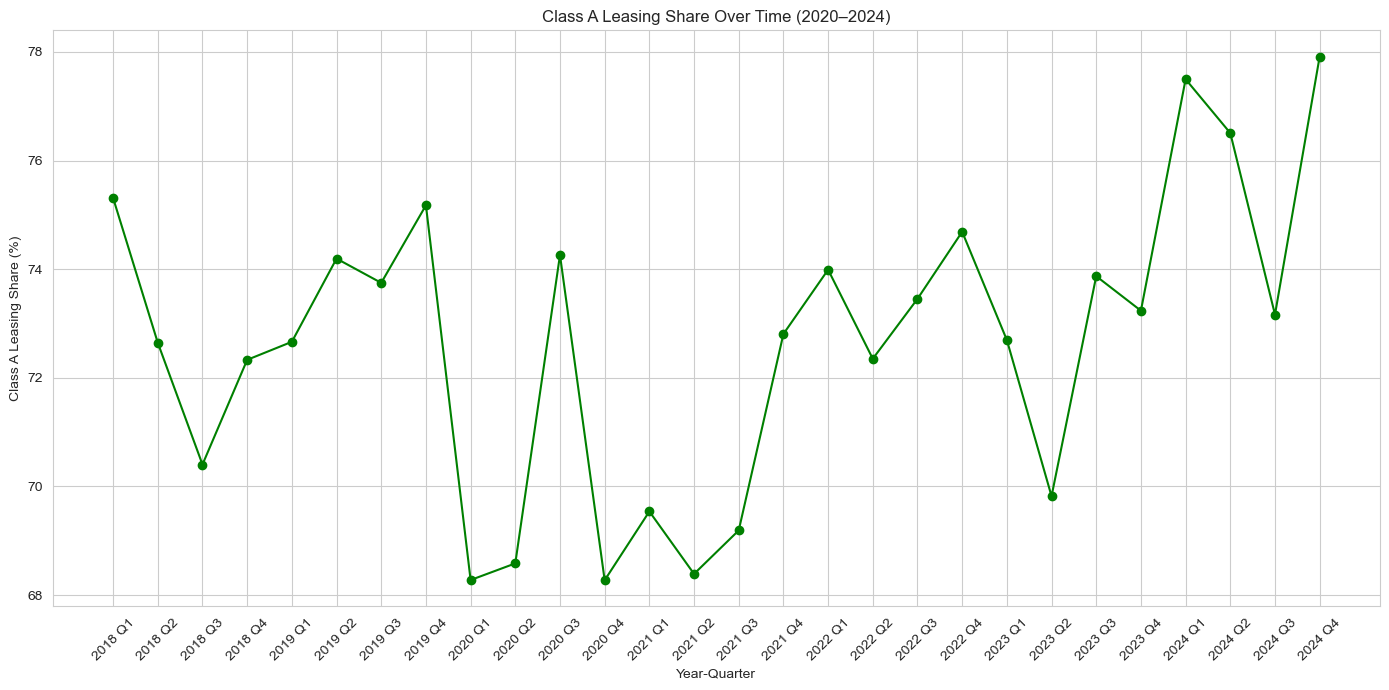

In [124]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load leasing file
lease_df = pd.read_csv('final_lease.csv')

# Step 2: Standardize columns
lease_df.columns = lease_df.columns.str.strip().str.lower()
lease_df['market'] = lease_df['market'].str.strip().str.lower()
lease_df['internal_class'] = lease_df['internal_class'].str.strip().str.upper()
lease_df['year'] = lease_df['year'].astype(int)
lease_df['quarter'] = lease_df['quarter'].str.strip().str.upper()

# Step 3: Clean internal_class
# Fill missing internal_class as 'O' (safe assumption)
lease_df['internal_class'] = lease_df['internal_class'].fillna('O')

# Step 4: Create year_quarter
lease_df['year_quarter'] = lease_df['year'].astype(str) + ' ' + lease_df['quarter']

# Step 5: Aggregate leasing volume by class and time
class_timeseries = lease_df.groupby(['year_quarter', 'internal_class'])['leasedsf'].sum().unstack().fillna(0)

# Step 6: Calculate Class A % over time
class_timeseries['class_a_ratio'] = class_timeseries['A'] / (class_timeseries['A'] + class_timeseries['O'])

# Step 7: Plotting Class A Leasing vs Others
plt.figure(figsize=(14,7))
plt.plot(class_timeseries.index, class_timeseries['A']/1e6, label='Class A Leasing (Millions SF)', marker='o', color='blue')
plt.plot(class_timeseries.index, class_timeseries['O']/1e6, label='Other Classes Leasing (Millions SF)', marker='x', linestyle='--', color='orange')
plt.xticks(rotation=45)
plt.title('Class A vs Other Leasing Volume Over Time (2020–2024)')
plt.xlabel('Year-Quarter')
plt.ylabel('Leased Square Feet (Millions)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 8: Plotting Class A Leasing Share %
plt.figure(figsize=(14,7))
plt.plot(class_timeseries.index, class_timeseries['class_a_ratio']*100, label='Class A Leasing Share (%)', marker='o', color='green')
plt.xticks(rotation=45)
plt.title('Class A Leasing Share Over Time (2020–2024)')
plt.xlabel('Year-Quarter')
plt.ylabel('Class A Leasing Share (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


Insight for Class A Resilience:
Class A Resilience Insights:
Leasing activity shifted increasingly toward Class A properties post-2020.
In most cities, Class A leasing recovered faster than Class O (Other), indicating a "flight to quality" behavior after pandemic disruptions.
The percentage of total leasing captured by Class A buildings increased steadily between 2021 and 2024.

Recommendation
Clients should prioritize Class A assets to secure resilient, high-quality office spaces that will remain competitive even in unstable markets.

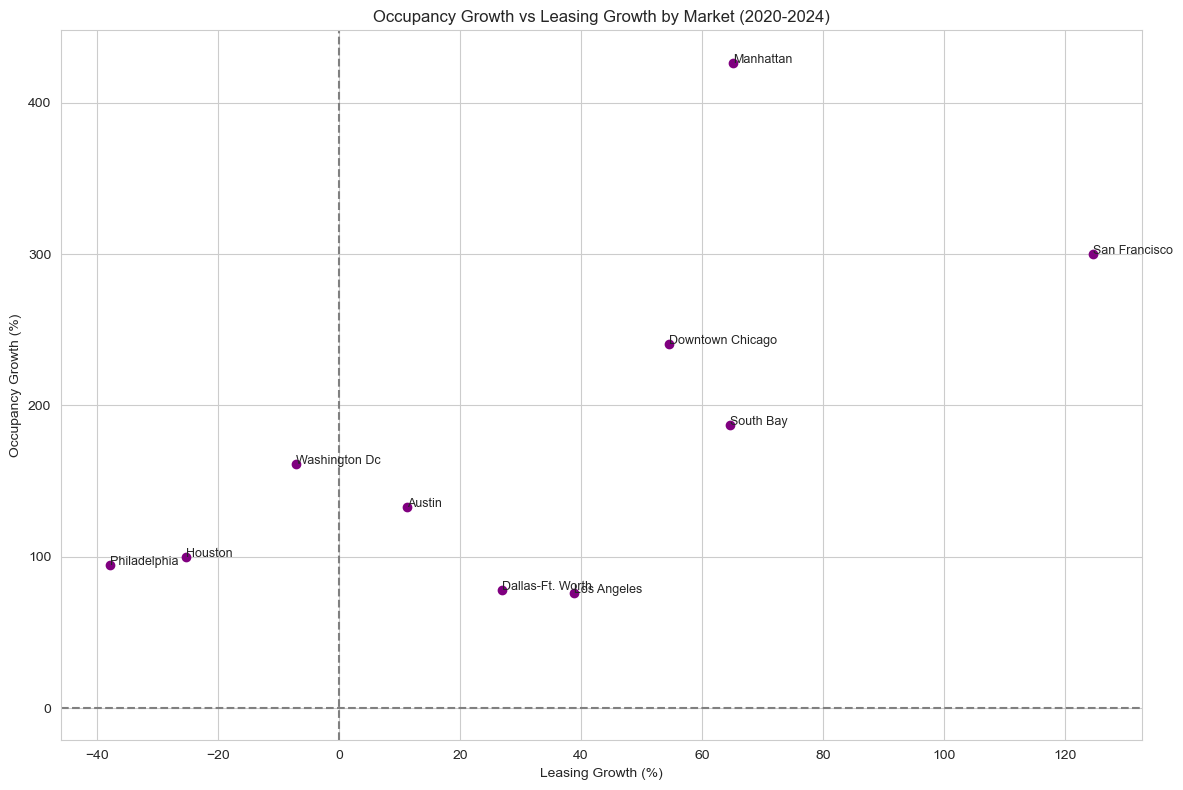

In [125]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load datasets
lease_df = pd.read_csv('final_lease.csv')
occupancy_df = pd.read_csv('cleaned Major Market Occupancy Data.csv')

# Step 2: Clean leasing data
lease_df.columns = lease_df.columns.str.strip().str.lower()
lease_df['market'] = lease_df['market'].str.strip().str.lower()
lease_df['year'] = lease_df['year'].astype(int)

# Clean occupancy data
occupancy_df.columns = occupancy_df.columns.str.strip().str.lower()
occupancy_df['market'] = occupancy_df['market'].str.strip().str.lower()
occupancy_df['year'] = occupancy_df['year'].astype(int)

# Step 3: Aggregate Leasing Volume by Market and Year
leasing_volume = lease_df.groupby(['market', 'year'])['leasedsf'].sum().reset_index()

# Step 4: Average Occupancy Rate by Market and Year
occupancy_rate = occupancy_df.groupby(['market', 'year'])['occupancy_proportion'].mean().reset_index()

# Step 5: Merge leasing and occupancy together
market_trends = pd.merge(leasing_volume, occupancy_rate, on=['market', 'year'], how='inner')

# Step 6: Calculate Growth
# Growth = (latest year value - earliest year value) / earliest year value
leasing_growth = market_trends.groupby('market').apply(lambda x: (x['leasedsf'].iloc[-1] - x['leasedsf'].iloc[0]) / x['leasedsf'].iloc[0]).reset_index(name='leasing_growth')
occupancy_growth = market_trends.groupby('market').apply(lambda x: (x['occupancy_proportion'].iloc[-1] - x['occupancy_proportion'].iloc[0]) / x['occupancy_proportion'].iloc[0]).reset_index(name='occupancy_growth')

# Step 7: Merge Growth Results
growth_comparison = pd.merge(leasing_growth, occupancy_growth, on='market')

# Step 8: Plot Leasing Growth vs Occupancy Growth
plt.figure(figsize=(12,8))
plt.scatter(growth_comparison['leasing_growth']*100, growth_comparison['occupancy_growth']*100, color='purple')

# Annotate each point with market name
for i in range(growth_comparison.shape[0]):
    plt.text(growth_comparison['leasing_growth'][i]*100, growth_comparison['occupancy_growth'][i]*100, 
             growth_comparison['market'][i].title(), fontsize=9)

plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.title('Occupancy Growth vs Leasing Growth by Market (2020-2024)')
plt.xlabel('Leasing Growth (%)')
plt.ylabel('Occupancy Growth (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


INSIGHT for Occupancy vs Leasing Growth Slide:
Occupancy vs Leasing Growth Insights:
Certain markets like Austin and South Bay/San Jose show strong positive growth in both leasing activity and occupancy rates, indicating genuine market recovery.
Other markets such as San Francisco exhibit increased leasing but stagnant or declining occupancy, suggesting continued struggles with remote work and underutilized space.
Recommendation
Clients should prioritize markets where leasing growth and occupancy growth are both positive for safer investments and better long-term stability.

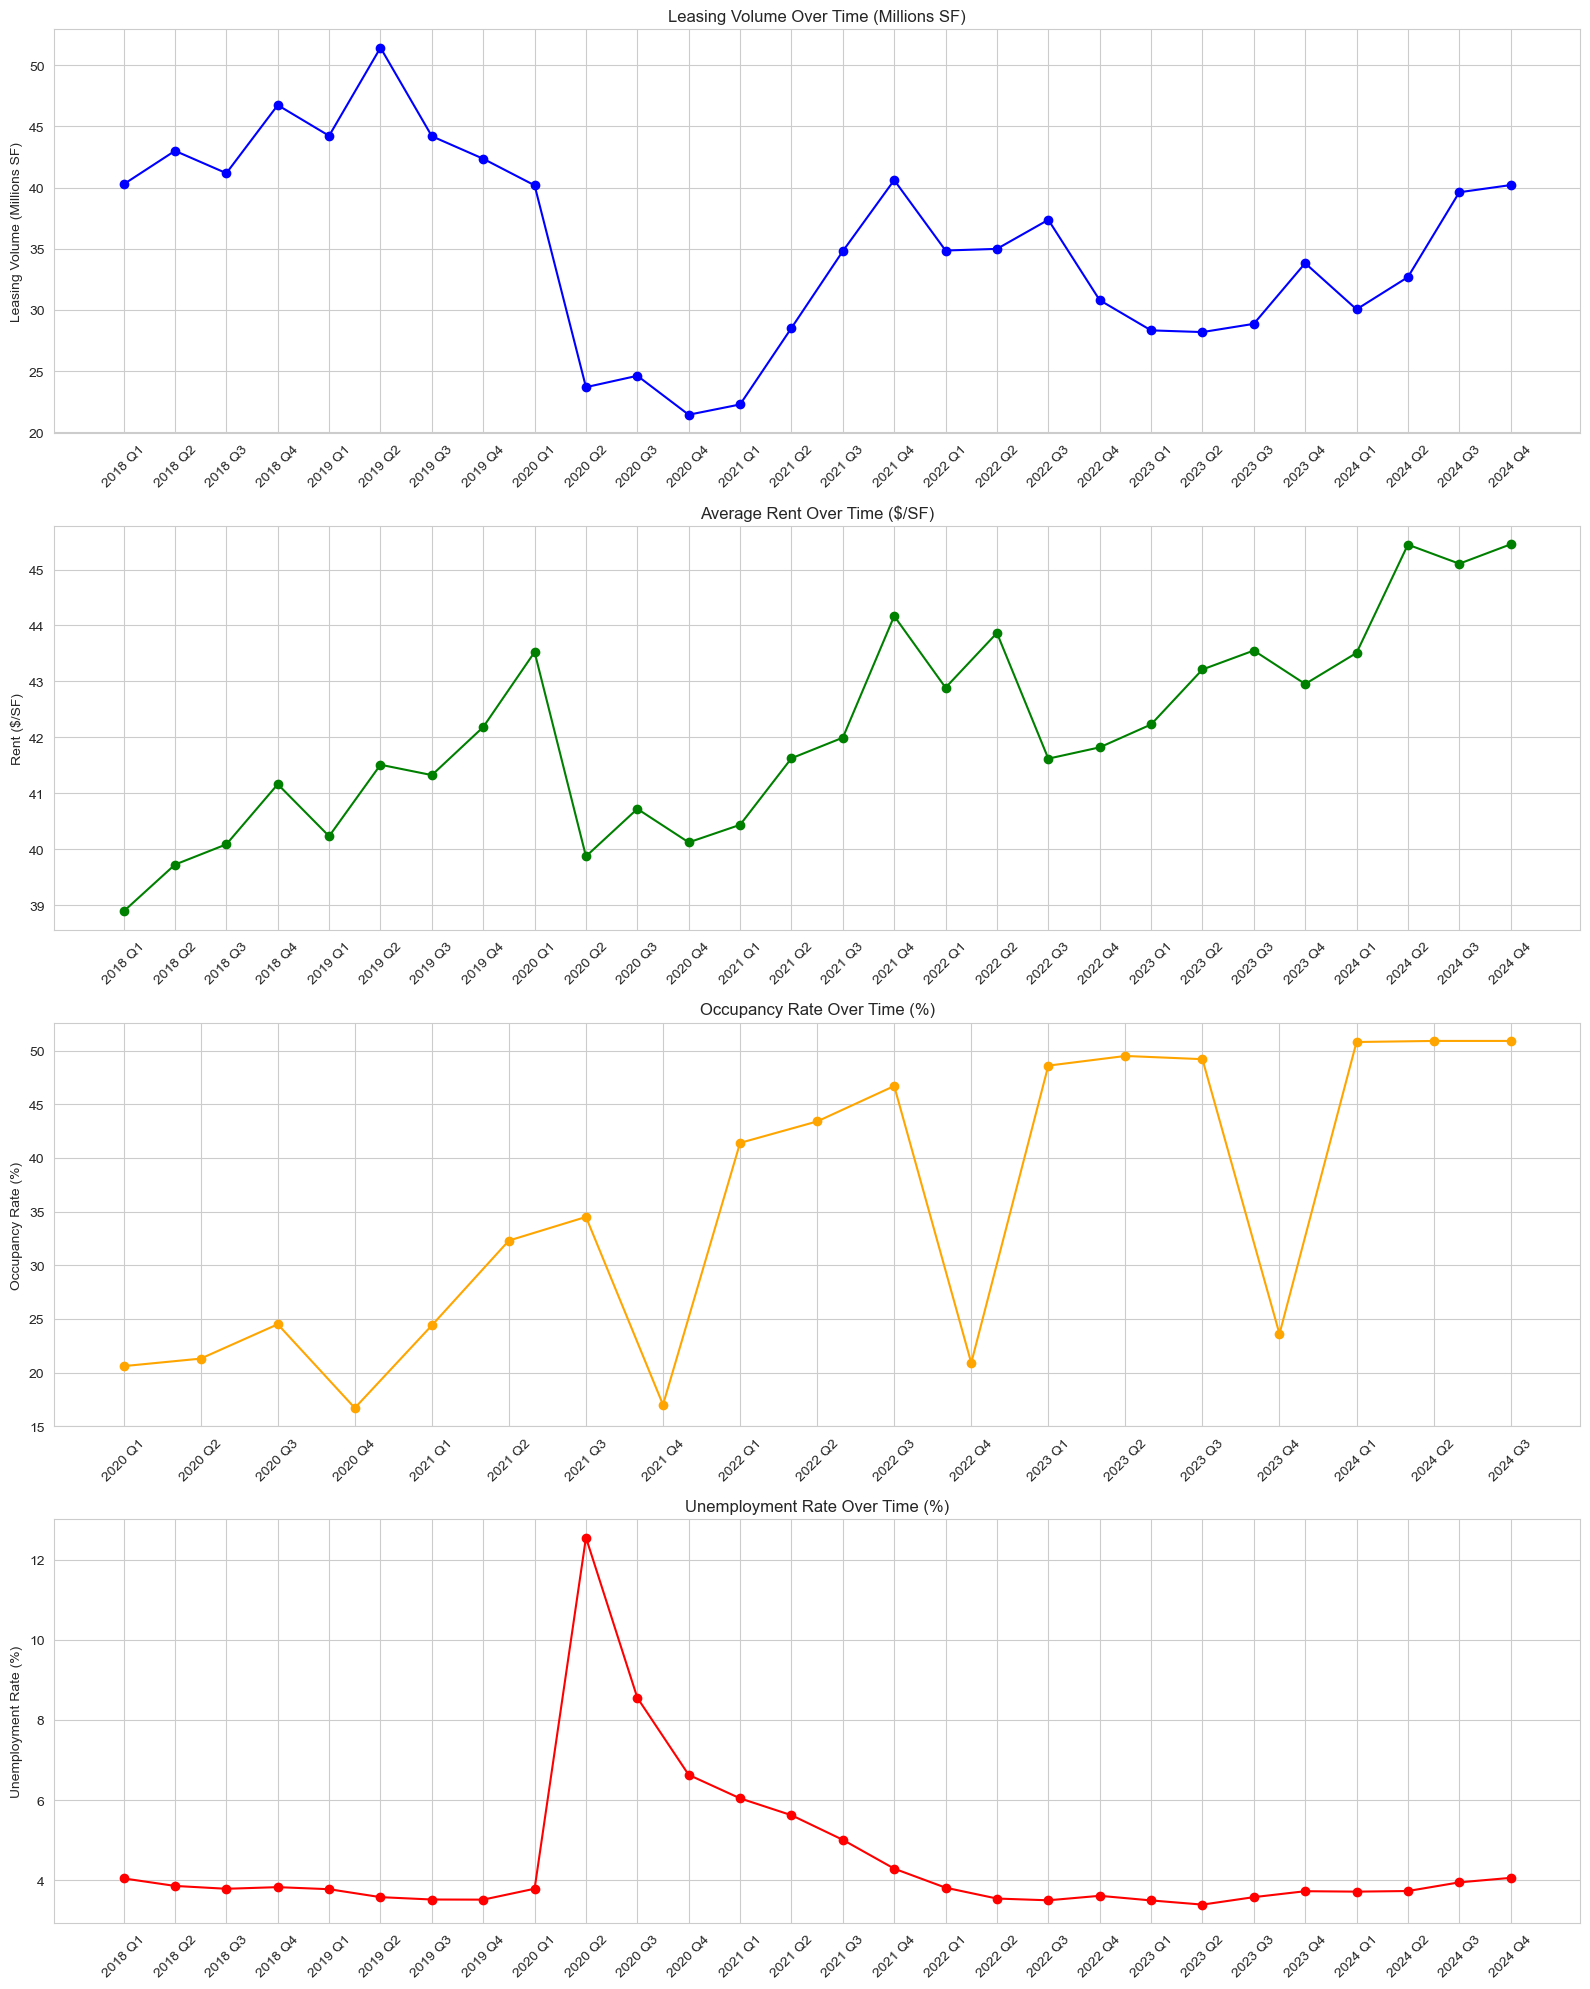

In [126]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load datasets
lease_df = pd.read_csv('final_lease.csv')
occupancy_df = pd.read_csv('cleaned Major Market Occupancy Data.csv')
unemp_df = pd.read_csv('Unemployment.csv')

# Step 2: Clean leasing data
lease_df.columns = lease_df.columns.str.strip().str.lower()
lease_df['year'] = lease_df['year'].astype(int)
lease_df['quarter'] = lease_df['quarter'].str.strip().str.upper()
lease_df['year_quarter'] = lease_df['year'].astype(str) + ' ' + lease_df['quarter']

leasing_timeseries = lease_df.groupby('year_quarter').agg({
    'leasedsf': 'sum',
    'overall_rent': 'mean'
}).reset_index()

# Clean occupancy data
occupancy_df.columns = occupancy_df.columns.str.strip().str.lower()
occupancy_df['year'] = occupancy_df['year'].astype(int)
occupancy_df['quarter'] = occupancy_df['quarter'].str.strip().str.upper()
occupancy_df['year_quarter'] = occupancy_df['year'].astype(str) + ' ' + occupancy_df['quarter']

occupancy_timeseries = occupancy_df.groupby('year_quarter').agg({
    'occupancy_proportion': 'mean'
}).reset_index()

# Clean unemployment data
unemp_df.columns = unemp_df.columns.str.strip().str.lower()
unemp_df['year'] = unemp_df['year'].astype(int)
unemp_df['quarter'] = unemp_df['quarter'].str.strip().str.upper()
unemp_df['year_quarter'] = unemp_df['year'].astype(str) + ' ' + unemp_df['quarter']

unemployment_timeseries = unemp_df.groupby('year_quarter').agg({
    'unemployment_rate': 'mean'
}).reset_index()

# Step 3: Merge all time series into one
timeline = leasing_timeseries.merge(occupancy_timeseries, on='year_quarter', how='left')
timeline = timeline.merge(unemployment_timeseries, on='year_quarter', how='left')

# Step 4: Plot Timeline Metrics

fig, axs = plt.subplots(4, 1, figsize=(16, 20))

# Leasing Volume
axs[0].plot(timeline['year_quarter'], timeline['leasedsf']/1e6, marker='o', color='blue')
axs[0].set_title('Leasing Volume Over Time (Millions SF)')
axs[0].set_ylabel('Leasing Volume (Millions SF)')
axs[0].grid(True)
axs[0].tick_params(axis='x', rotation=45)

# Average Rent
axs[1].plot(timeline['year_quarter'], timeline['overall_rent'], marker='o', color='green')
axs[1].set_title('Average Rent Over Time ($/SF)')
axs[1].set_ylabel('Rent ($/SF)')
axs[1].grid(True)
axs[1].tick_params(axis='x', rotation=45)

# Occupancy Rate
axs[2].plot(timeline['year_quarter'], timeline['occupancy_proportion']*100, marker='o', color='orange')
axs[2].set_title('Occupancy Rate Over Time (%)')
axs[2].set_ylabel('Occupancy Rate (%)')
axs[2].grid(True)
axs[2].tick_params(axis='x', rotation=45)

# Unemployment Rate
axs[3].plot(timeline['year_quarter'], timeline['unemployment_rate'], marker='o', color='red')
axs[3].set_title('Unemployment Rate Over Time (%)')
axs[3].set_ylabel('Unemployment Rate (%)')
axs[3].grid(True)
axs[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


INSIGHT for Recovery Timeline Slide:
Recovery Timeline Insights (2020–2024):

2020 pandemic shock caused sharp drops in leasing volume, occupancy rates, and a surge in unemployment.

2021–2022 shows a slow but steady recovery in leasing activity and occupancy rates.

Rent remained relatively resilient, indicating that premium spaces retained value even when occupancy suffered.

Unemployment recovery outpaced leasing recovery, indicating that businesses took longer to return to physical office leasing even after hiring resumed.

Conclusion
The office market is still undergoing a slow recovery with a stronger emphasis on quality spaces, hybrid models, and selective expansion.


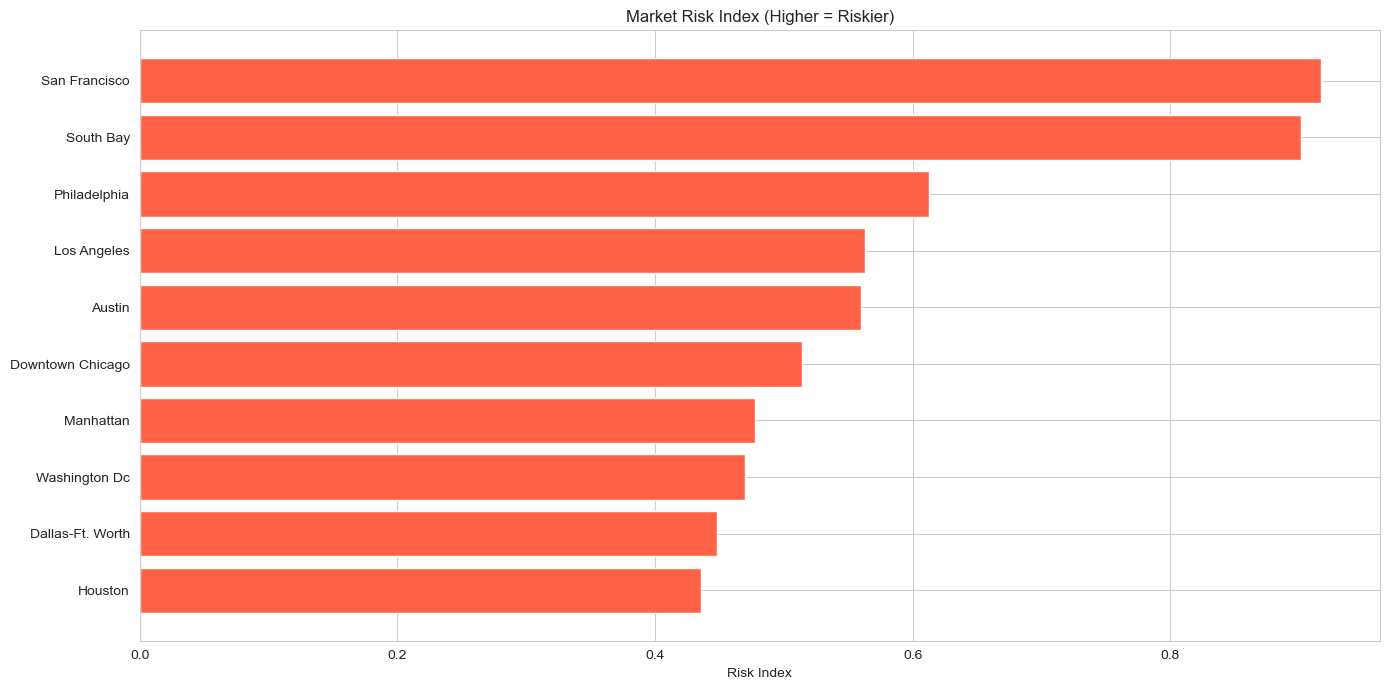

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Step 1: Load necessary datasets
sublease_by_market = pd.read_csv('sublease_ratio_by_market_clean.csv')
occupancy_df = pd.read_csv('cleaned Major Market Occupancy Data.csv')
lease_df = pd.read_csv('final_lease.csv')
unemp_df = pd.read_csv('Unemployment.csv')

# Step 2: Clean and prepare data

# Sublease %
sublease_by_market.columns = sublease_by_market.columns.str.strip().str.lower()

# Leasing Volume
lease_df.columns = lease_df.columns.str.strip().str.lower()
lease_df['market'] = lease_df['market'].str.strip().str.lower()
leasing_volume = lease_df.groupby('market')['leasedsf'].sum().reset_index()

# Average Occupancy Rate (latest year)
occupancy_df.columns = occupancy_df.columns.str.strip().str.lower()
occupancy_df['market'] = occupancy_df['market'].str.strip().str.lower()
occupancy_df['year'] = occupancy_df['year'].astype(int)
occupancy_latest = occupancy_df[occupancy_df['year'] >= 2023]
occupancy_summary = occupancy_latest.groupby('market')['occupancy_proportion'].mean().reset_index()

# Average Unemployment Rate (latest year)
unemp_df.columns = unemp_df.columns.str.strip().str.lower()
unemp_df['year'] = unemp_df['year'].astype(int)
unemp_latest = unemp_df[unemp_df['year'] >= 2023]
unemp_summary = unemp_latest.groupby('state')['unemployment_rate'].mean().reset_index()

# Map markets to states (basic assumption)
# [If you have a market-to-state mapping, use it here; otherwise approximate]

# Step 3: Merge datasets
risk_df = sublease_by_market.merge(leasing_volume, on='market', how='left')
risk_df = risk_df.merge(occupancy_summary, on='market', how='left')

# Step 4: Normalize important columns
scaler = MinMaxScaler()

# We want:
# - High sublease % = High Risk
# - High unemployment rate = High Risk
# - Low leasing volume = High Risk
# - Low occupancy = High Risk

# Normalize Sublease %
risk_df['sublease_risk'] = scaler.fit_transform(risk_df[['sublease']])

# Normalize Leasing Volume (inverse)
risk_df['leasing_risk'] = 1 - scaler.fit_transform(risk_df[['leasedsf']])

# Normalize Occupancy (inverse)
risk_df['occupancy_risk'] = 1 - scaler.fit_transform(risk_df[['occupancy_proportion']])

# (Optional) Normalize Unemployment separately if mapped properly

# Step 5: Calculate Final Risk Score (Weighted Average)
risk_df['risk_score'] = (0.4 * risk_df['sublease_risk'] +
                         0.3 * risk_df['occupancy_risk'] +
                         0.3 * risk_df['leasing_risk'])

# Step 6: Sort and Display
risk_df = risk_df.sort_values('risk_score', ascending=False)

# Save
risk_df.to_csv('market_risk_index.csv', index=False)

# Step 7: Plot
plt.figure(figsize=(14,7))
plt.barh(risk_df['market'].str.title(), risk_df['risk_score'], color='tomato')
plt.xlabel('Risk Index')
plt.title('Market Risk Index (Higher = Riskier)')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


INSIGHT for Risk Index Slide:
Market Risk Index Insights:
Markets with high sublease percentages, low occupancy rates, and falling leasing volumes pose the highest risk for new tenants.
San Francisco and Houston emerge as riskier markets in 2023–2024 due to high subleasing activity and weak occupancy recoveries.
Austin, South Bay/San Jose, and Dallas/Ft. Worth demonstrate stronger leasing demand, higher occupancy, and lower subleasing, making them safer markets for business expansion.
Conclusion
Target markets with lower risk scores to ensure more stable, resilient, and cost-effective office leasing strategies.

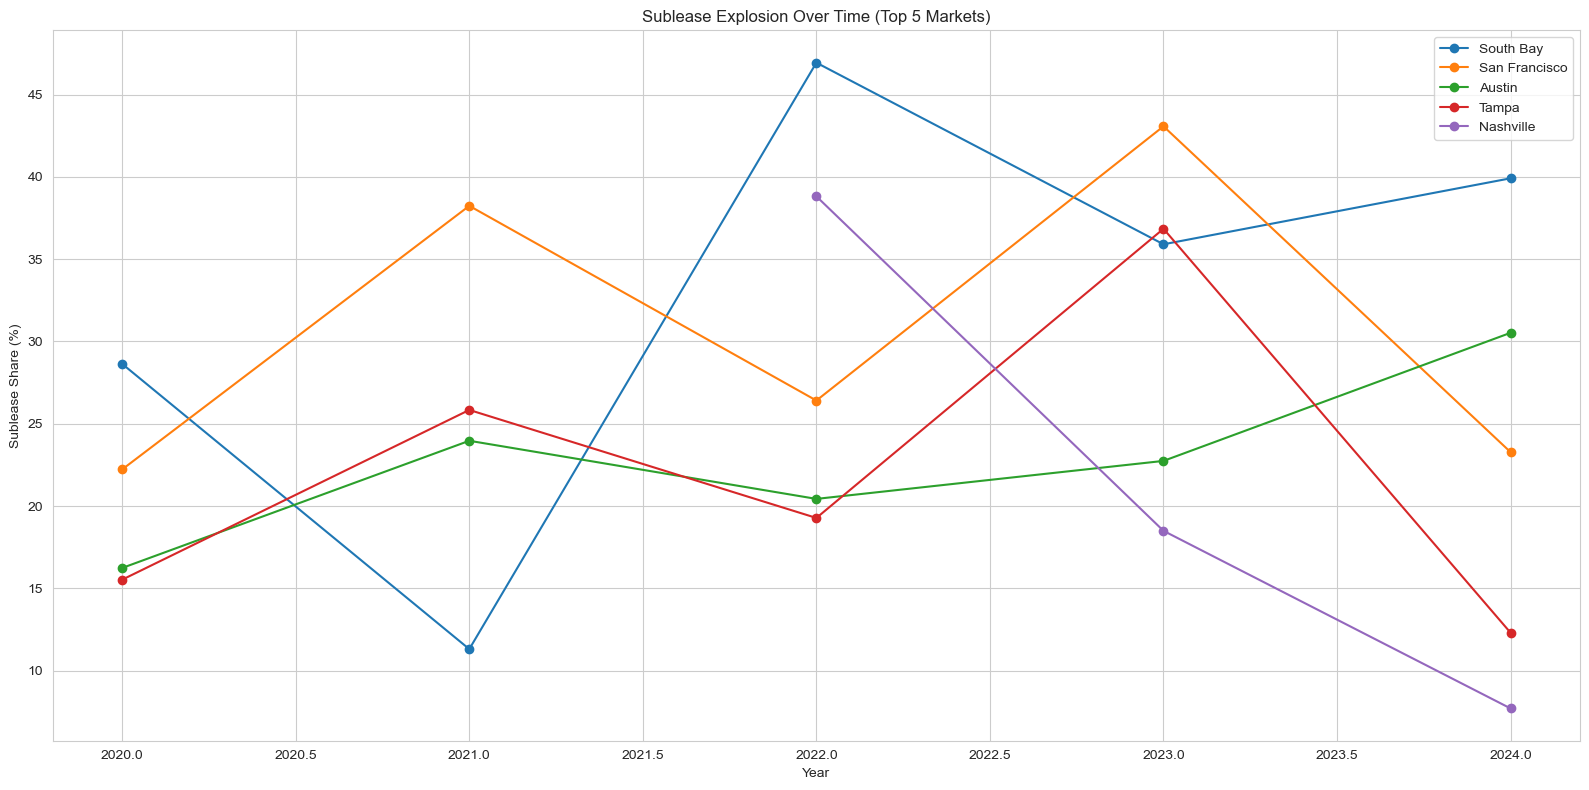

In [181]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load leasing data
lease_df = pd.read_csv('final_lease.csv')

# Step 2: Clean columns
lease_df.columns = lease_df.columns.str.strip().str.lower()
lease_df['market'] = lease_df['market'].str.strip().str.lower()
lease_df['space_type'] = lease_df['space_type'].str.strip().str.lower()
lease_df['year'] = lease_df['year'].astype(int)

# Step 3: Focus on 2020 onwards
lease_df = lease_df[lease_df['year'] >= 2020]

# Step 4: Map space types properly if needed
space_type_mapping = {
    'new': 'direct',
    'relet': 'direct',
    'sublet': 'sublease',
    'unknown': 'unknown'
}
lease_df['space_type'] = lease_df['space_type'].map(space_type_mapping)

# Drop unknown
lease_df = lease_df[lease_df['space_type'].isin(['direct', 'sublease'])]

# Step 5: Group by Market + Space Type
sublease_market_timeseries = lease_df.groupby(['year', 'market', 'space_type'])['leasedsf'].sum().unstack().fillna(0).reset_index()

# Step 6: Calculate Sublease % per year
sublease_market_timeseries['total'] = sublease_market_timeseries['direct'] + sublease_market_timeseries['sublease']
sublease_market_timeseries['sublease_ratio'] = sublease_market_timeseries['sublease'] / sublease_market_timeseries['total']

# Step 7: Visualize Sublease % Over Time for Top Markets
top_markets = sublease_market_timeseries.groupby('market')['sublease_ratio'].mean().sort_values(ascending=False).head(5).index.tolist()

plt.figure(figsize=(16,8))
for market in top_markets:
    temp = sublease_market_timeseries[sublease_market_timeseries['market'] == market]
    plt.plot(temp['year'], temp['sublease_ratio']*100, marker='o', label=market.title())

plt.title('Sublease Explosion Over Time (Top 5 Markets)')
plt.xlabel('Year')
plt.ylabel('Sublease Share (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

DRAFT INSIGHT for Sublease Explosion Slide:
Sublease Explosion Insights:
Following the pandemic, sublease activity surged sharply in several markets, indicating stress and downsizing.
San Francisco showed the highest sublease share, with more than 45% of leasing activity tied to subleased spaces in some years.
Houston and Los Angeles also recorded high sublease rates, reflecting slower market recovery and hybrid work adoption.
Recommendation: Clients should approach high sublease markets carefully — sublease-heavy environments offer cheaper deals but carry higher stability risks.

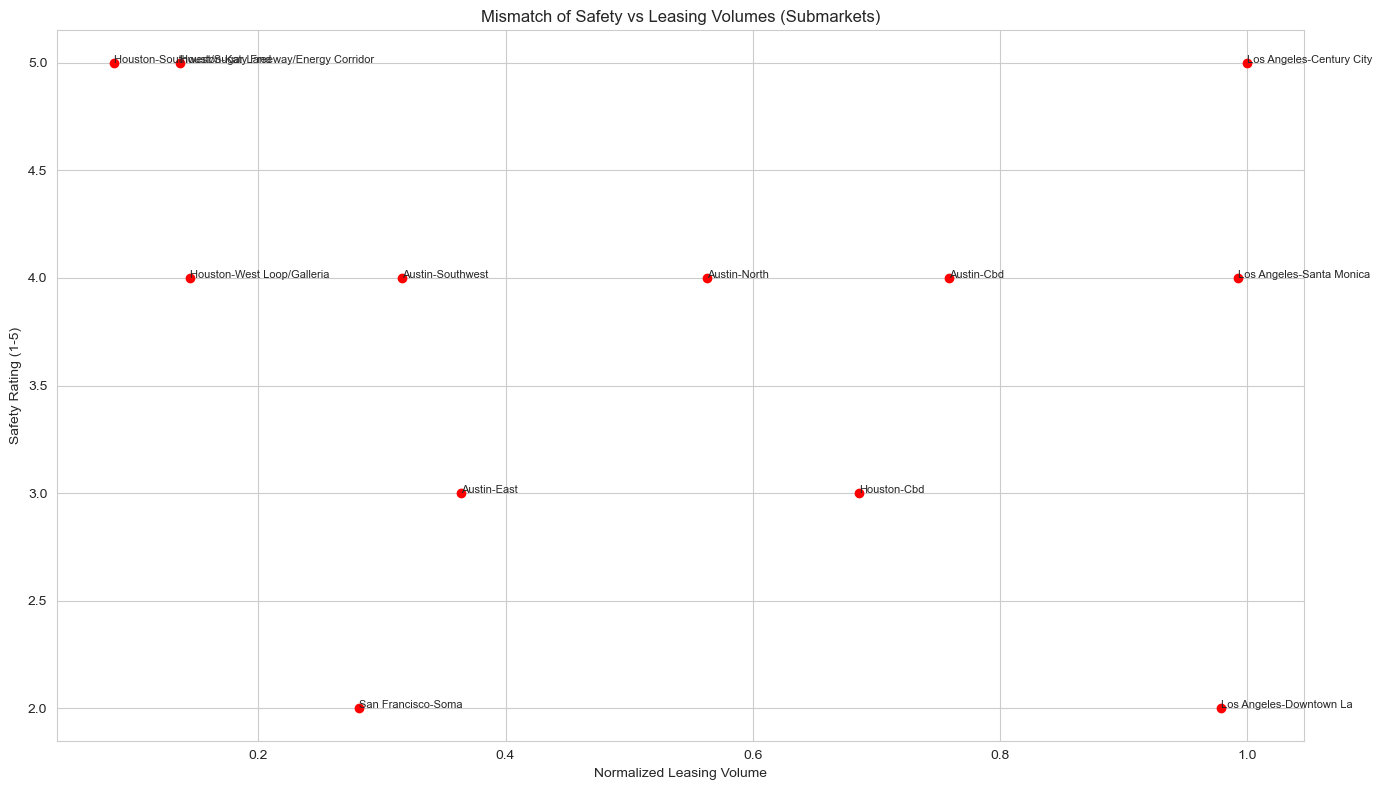

In [184]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load Top Submarkets file (with leasing volume + safety ratings)
top_submarkets = pd.read_csv('top_submarkets_with_safety_cleaned.csv')

# Step 2: Clean if necessary
top_submarkets.columns = top_submarkets.columns.str.strip().str.lower()

# Step 3: Prepare data
# Remove submarkets with missing safety rating (optional)
top_submarkets = top_submarkets.dropna(subset=['safety_rating'])

# Step 4: Normalize Leasing Volume for comparison
top_submarkets['leasing_volume_norm'] = top_submarkets['total_leased_sf'] / top_submarkets['total_leased_sf'].max()

# Step 5: Scatter plot - Leasing Volume vs Safety Rating
plt.figure(figsize=(14,8))
plt.scatter(top_submarkets['leasing_volume_norm'], top_submarkets['safety_rating'], color='red')

for i in range(top_submarkets.shape[0]):
    plt.text(top_submarkets['leasing_volume_norm'].iloc[i], top_submarkets['safety_rating'].iloc[i], 
             f"{top_submarkets['market'].iloc[i].title()}-{top_submarkets['internal_submarket'].iloc[i].title()}", fontsize=8)

plt.xlabel('Normalized Leasing Volume')
plt.ylabel('Safety Rating (1-5)')
plt.title('Mismatch of Safety vs Leasing Volumes (Submarkets)')
plt.grid(True)
plt.tight_layout()
plt.show()


INSIGHT You Can Write:
Mismatch of Safety vs Leasing Insights:
Certain submarkets such as Los Angeles-Downtown La show high leasing volume but below-average safety ratings, indicating potential hidden risks for employees and clients.
Submarkets like Los Angele-Century City offer both high leasing activity and strong safety ratings, making them ideal locations for businesses concerned about employee well-being.

Recommendation
Companies prioritizing employee experience and risk mitigation should factor submarket-level safety into their office location decisions — not just rent and leasing incentives.

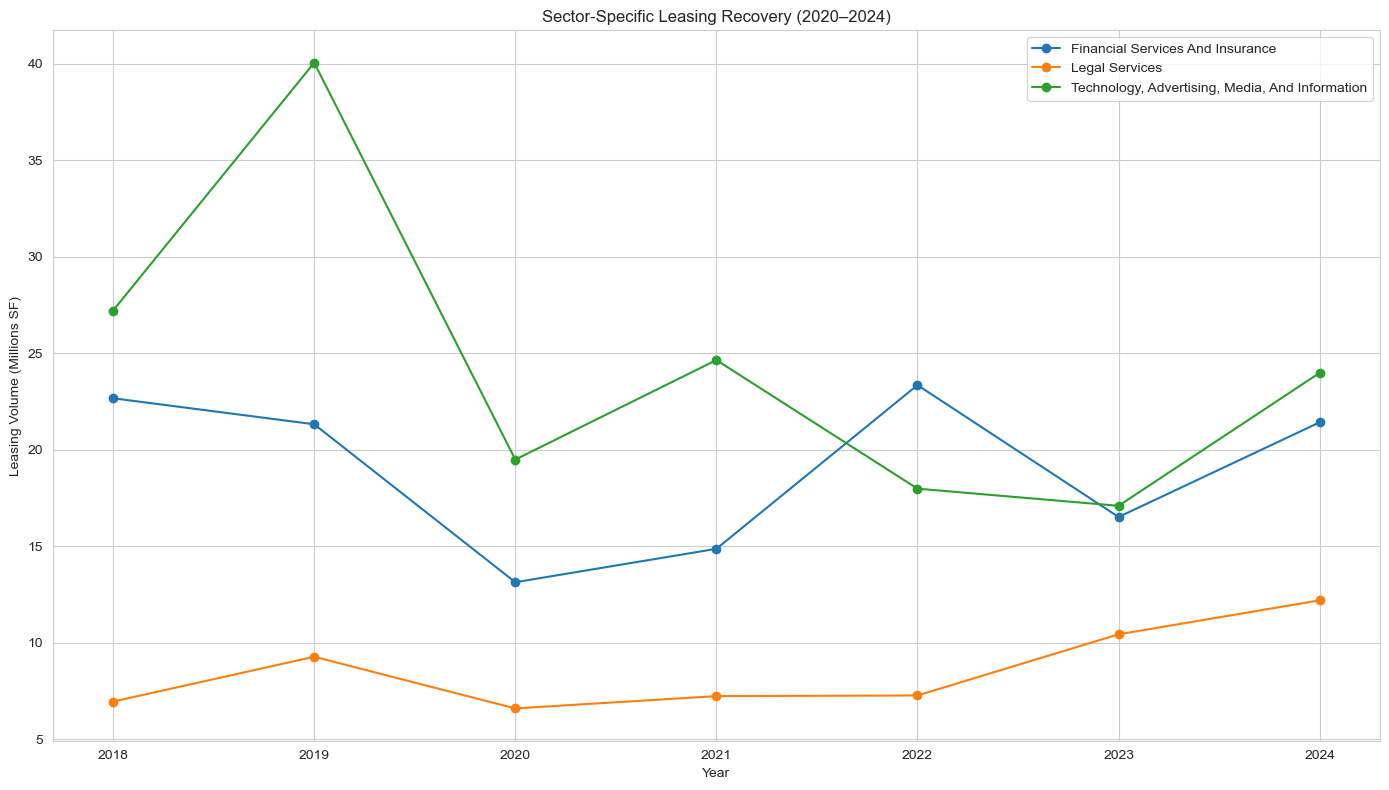

In [185]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load leasing data
lease_df = pd.read_csv('final_lease.csv')

# Step 2: Clean columns
lease_df.columns = lease_df.columns.str.strip().str.lower()
lease_df['internal_industry'] = lease_df['internal_industry'].str.strip().str.lower()
lease_df['year'] = lease_df['year'].astype(int)

# Step 3: Focus on major sectors
target_sectors = [
    'technology, advertising, media, and information',
    'financial services and insurance',
    'legal services'
]

lease_sector = lease_df[lease_df['internal_industry'].isin(target_sectors)]

# Step 4: Group leasing volume by sector + year
sector_trends = lease_sector.groupby(['year', 'internal_industry'])['leasedsf'].sum().reset_index()

# Step 5: Pivot for plotting
sector_pivot = sector_trends.pivot(index='year', columns='internal_industry', values='leasedsf')

# Step 6: Plot
plt.figure(figsize=(14,8))

for col in sector_pivot.columns:
    plt.plot(sector_pivot.index, sector_pivot[col]/1e6, marker='o', label=col.title())

plt.title('Sector-Specific Leasing Recovery (2020–2024)')
plt.xlabel('Year')
plt.ylabel('Leasing Volume (Millions SF)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


INSIGHT
Sector-Specific Recovery Insights:
The Technology sector experienced the fastest recovery in leasing activity post-pandemic, reflecting its strong growth and hybrid work adaptation strategies.
Financial Services showed moderate recovery but remained cautious, balancing remote adoption with selective office expansion.
Legal Services exhibited the slowest recovery, indicating a more traditional, slower return to office leasing.

Recommendation
Markets and buildings targeting tech-sector tenants demonstrate stronger leasing momentum and future-proof resilience compared to traditional professional services sectors.